# Libraries

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from autogluon.tabular import TabularDataset, TabularPredictor

import warnings
warnings.filterwarnings("ignore")

# Functions

In [197]:
def plot_cv_confusion_matrices(cv_scores, cv_preds, y_train, n_splits=10):
    """
    Plots confusion matrices for cross-validation predictions, 
    with each subplot displaying the accuracy for each fold and 
    the suptitle showing the mean accuracy across all folds.
    
    Parameters:
    - cv_scores: Cross-validation scores from `cross_val_score`
    - cv_preds: Predictions from `cross_val_predict`
    - y_train: The true labels of the training set
    - n_splits: Number of cross-validation folds (default is 10)
    """
    
    # Initialize subplots with 2 rows and 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(15, 8), dpi=150)
    
    # Store all accuracies for mean calculation
    accuracies = []
    
    # Loop through each fold and generate the confusion matrix
    for i in range(n_splits):
        # Select the test indices corresponding to this fold
        fold_indices = np.arange(len(y_train)) % n_splits == i
        
        # Extract the true labels and predicted labels for the current fold
        y_test_fold = y_train[fold_indices]
        preds_fold = cv_preds[fold_indices]
        
        # Compute the confusion matrix and accuracy for the current fold
        cm = confusion_matrix(y_test_fold, preds_fold)
        accuracy = accuracy_score(y_test_fold, preds_fold)
        accuracies.append(accuracy)
        
        # Plot the confusion matrix in the corresponding subplot
        ax = axes[i // 5, i % 5]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", ax=ax, colorbar=False)
        
        # Set the title to display the accuracy for this fold
        ax.set_title(f"Fold {i+1}\nAcc: {accuracy*100}%")
    
    # Compute the mean accuracy from cross_val_score
    mean_accuracy = np.mean(cv_scores)
    
    # Set the suptitle to display the mean accuracy
    fig.suptitle(f"Confusion Matrices for {n_splits}-Fold Cross Validation\nMean Acc: {mean_accuracy*100}%", fontsize=16)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

In [198]:
def plot_test_confusion_matrix(model, X_test, y_test):
    cm = confusion_matrix(y_test, model.predict(X_test))

    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", ax=ax)

    plt.title(f"Confusion Matrix for Test Dataset\nAcc: {accuracy_score(y_test, model.predict(X_test))*100}%")
    plt.show()

# Data

## Data Loading

In [199]:
df = pd.read_csv("../datasets/customer-data.csv")
df = df.drop("id", axis=1)
df.head()

age  gender      race driving_experience    education         income  \
0    65+  female  majority               0-9y  high school    upper class   
1  16-25    male  majority               0-9y         none        poverty   
2  16-25  female  majority               0-9y  high school  working class   
3  16-25    male  majority               0-9y   university  working class   
4  26-39    male  majority             10-19y         none  working class   

   credit_score  vehicle_ownership vehicle_year  married  children  \
0      0.629027               True   after 2015    False      True   
1      0.357757              False  before 2015    False     False   
2      0.493146               True  before 2015    False     False   
3      0.206013               True  before 2015    False      True   
4      0.388366               True  before 2015    False     False   

   postal_code  annual_mileage vehicle_type  speeding_violations  DUIs  \
0        10238         12000.0        sedan                    0     0   
1        10238         16000.0        sedan                    0     0   
2        10238         11000.0        sedan                    0     0   
3        32765         11000.0        sedan                    0     0   
4        32765         12000.0        sedan                    2     0   

   past_accidents  outcome  
0               0    False  
1               0     True  
2               0    False  
3               0    False  
4               1     True

In [200]:
null = df.isnull().sum().sort_values(ascending=False)

df_null = pd.DataFrame(
    index=null.index,
    data={
        "null_count": null.values,
        "null_percentage": null.values / df.shape[0] * 100
    }
)
df_null

null_count  null_percentage
credit_score                982             9.82
annual_mileage              957             9.57
age                           0             0.00
children                      0             0.00
past_accidents                0             0.00
DUIs                          0             0.00
speeding_violations           0             0.00
vehicle_type                  0             0.00
postal_code                   0             0.00
married                       0             0.00
gender                        0             0.00
vehicle_year                  0             0.00
vehicle_ownership             0             0.00
income                        0             0.00
education                     0             0.00
driving_experience            0             0.00
race                          0             0.00
outcome                       0             0.00

## Missing Values

In [201]:
df.loc[:, "credit_score"] = df.groupby("income")["credit_score"].transform(lambda x: x.fillna(x.mean()))
df.loc[:, "annual_mileage"] = df.groupby("driving_experience")["annual_mileage"].transform(lambda x: x.fillna(x.mean()))

df.head()

age  gender      race driving_experience    education         income  \
0    65+  female  majority               0-9y  high school    upper class   
1  16-25    male  majority               0-9y         none        poverty   
2  16-25  female  majority               0-9y  high school  working class   
3  16-25    male  majority               0-9y   university  working class   
4  26-39    male  majority             10-19y         none  working class   

   credit_score  vehicle_ownership vehicle_year  married  children  \
0      0.629027               True   after 2015    False      True   
1      0.357757              False  before 2015    False     False   
2      0.493146               True  before 2015    False     False   
3      0.206013               True  before 2015    False      True   
4      0.388366               True  before 2015    False     False   

   postal_code  annual_mileage vehicle_type  speeding_violations  DUIs  \
0        10238         12000.0        sedan                    0     0   
1        10238         16000.0        sedan                    0     0   
2        10238         11000.0        sedan                    0     0   
3        32765         11000.0        sedan                    0     0   
4        32765         12000.0        sedan                    2     0   

   past_accidents  outcome  
0               0    False  
1               0     True  
2               0    False  
3               0    False  
4               1     True

## `postal_code`

In [202]:
df["postal_code"].value_counts()

postal_code
10238    6940
32765    2456
92101     484
21217     120
Name: count, dtype: int64

In [203]:
postal_code_map = {
    10238: "New York",
    32765: "Florida",
    92101: "California",
    21217: "Maryland"
}

df["state"] = df["postal_code"].map(postal_code_map)
df = df.drop("postal_code", axis=1)
df.head()

age  gender      race driving_experience    education         income  \
0    65+  female  majority               0-9y  high school    upper class   
1  16-25    male  majority               0-9y         none        poverty   
2  16-25  female  majority               0-9y  high school  working class   
3  16-25    male  majority               0-9y   university  working class   
4  26-39    male  majority             10-19y         none  working class   

   credit_score  vehicle_ownership vehicle_year  married  children  \
0      0.629027               True   after 2015    False      True   
1      0.357757              False  before 2015    False     False   
2      0.493146               True  before 2015    False     False   
3      0.206013               True  before 2015    False      True   
4      0.388366               True  before 2015    False     False   

   annual_mileage vehicle_type  speeding_violations  DUIs  past_accidents  \
0         12000.0        sedan                    0     0               0   
1         16000.0        sedan                    0     0               0   
2         11000.0        sedan                    0     0               0   
3         11000.0        sedan                    0     0               0   
4         12000.0        sedan                    2     0               1   

   outcome     state  
0    False  New York  
1     True  New York  
2    False  New York  
3    False   Florida  
4     True   Florida

## Who Needs EDA If We Have Daffa?

In [204]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

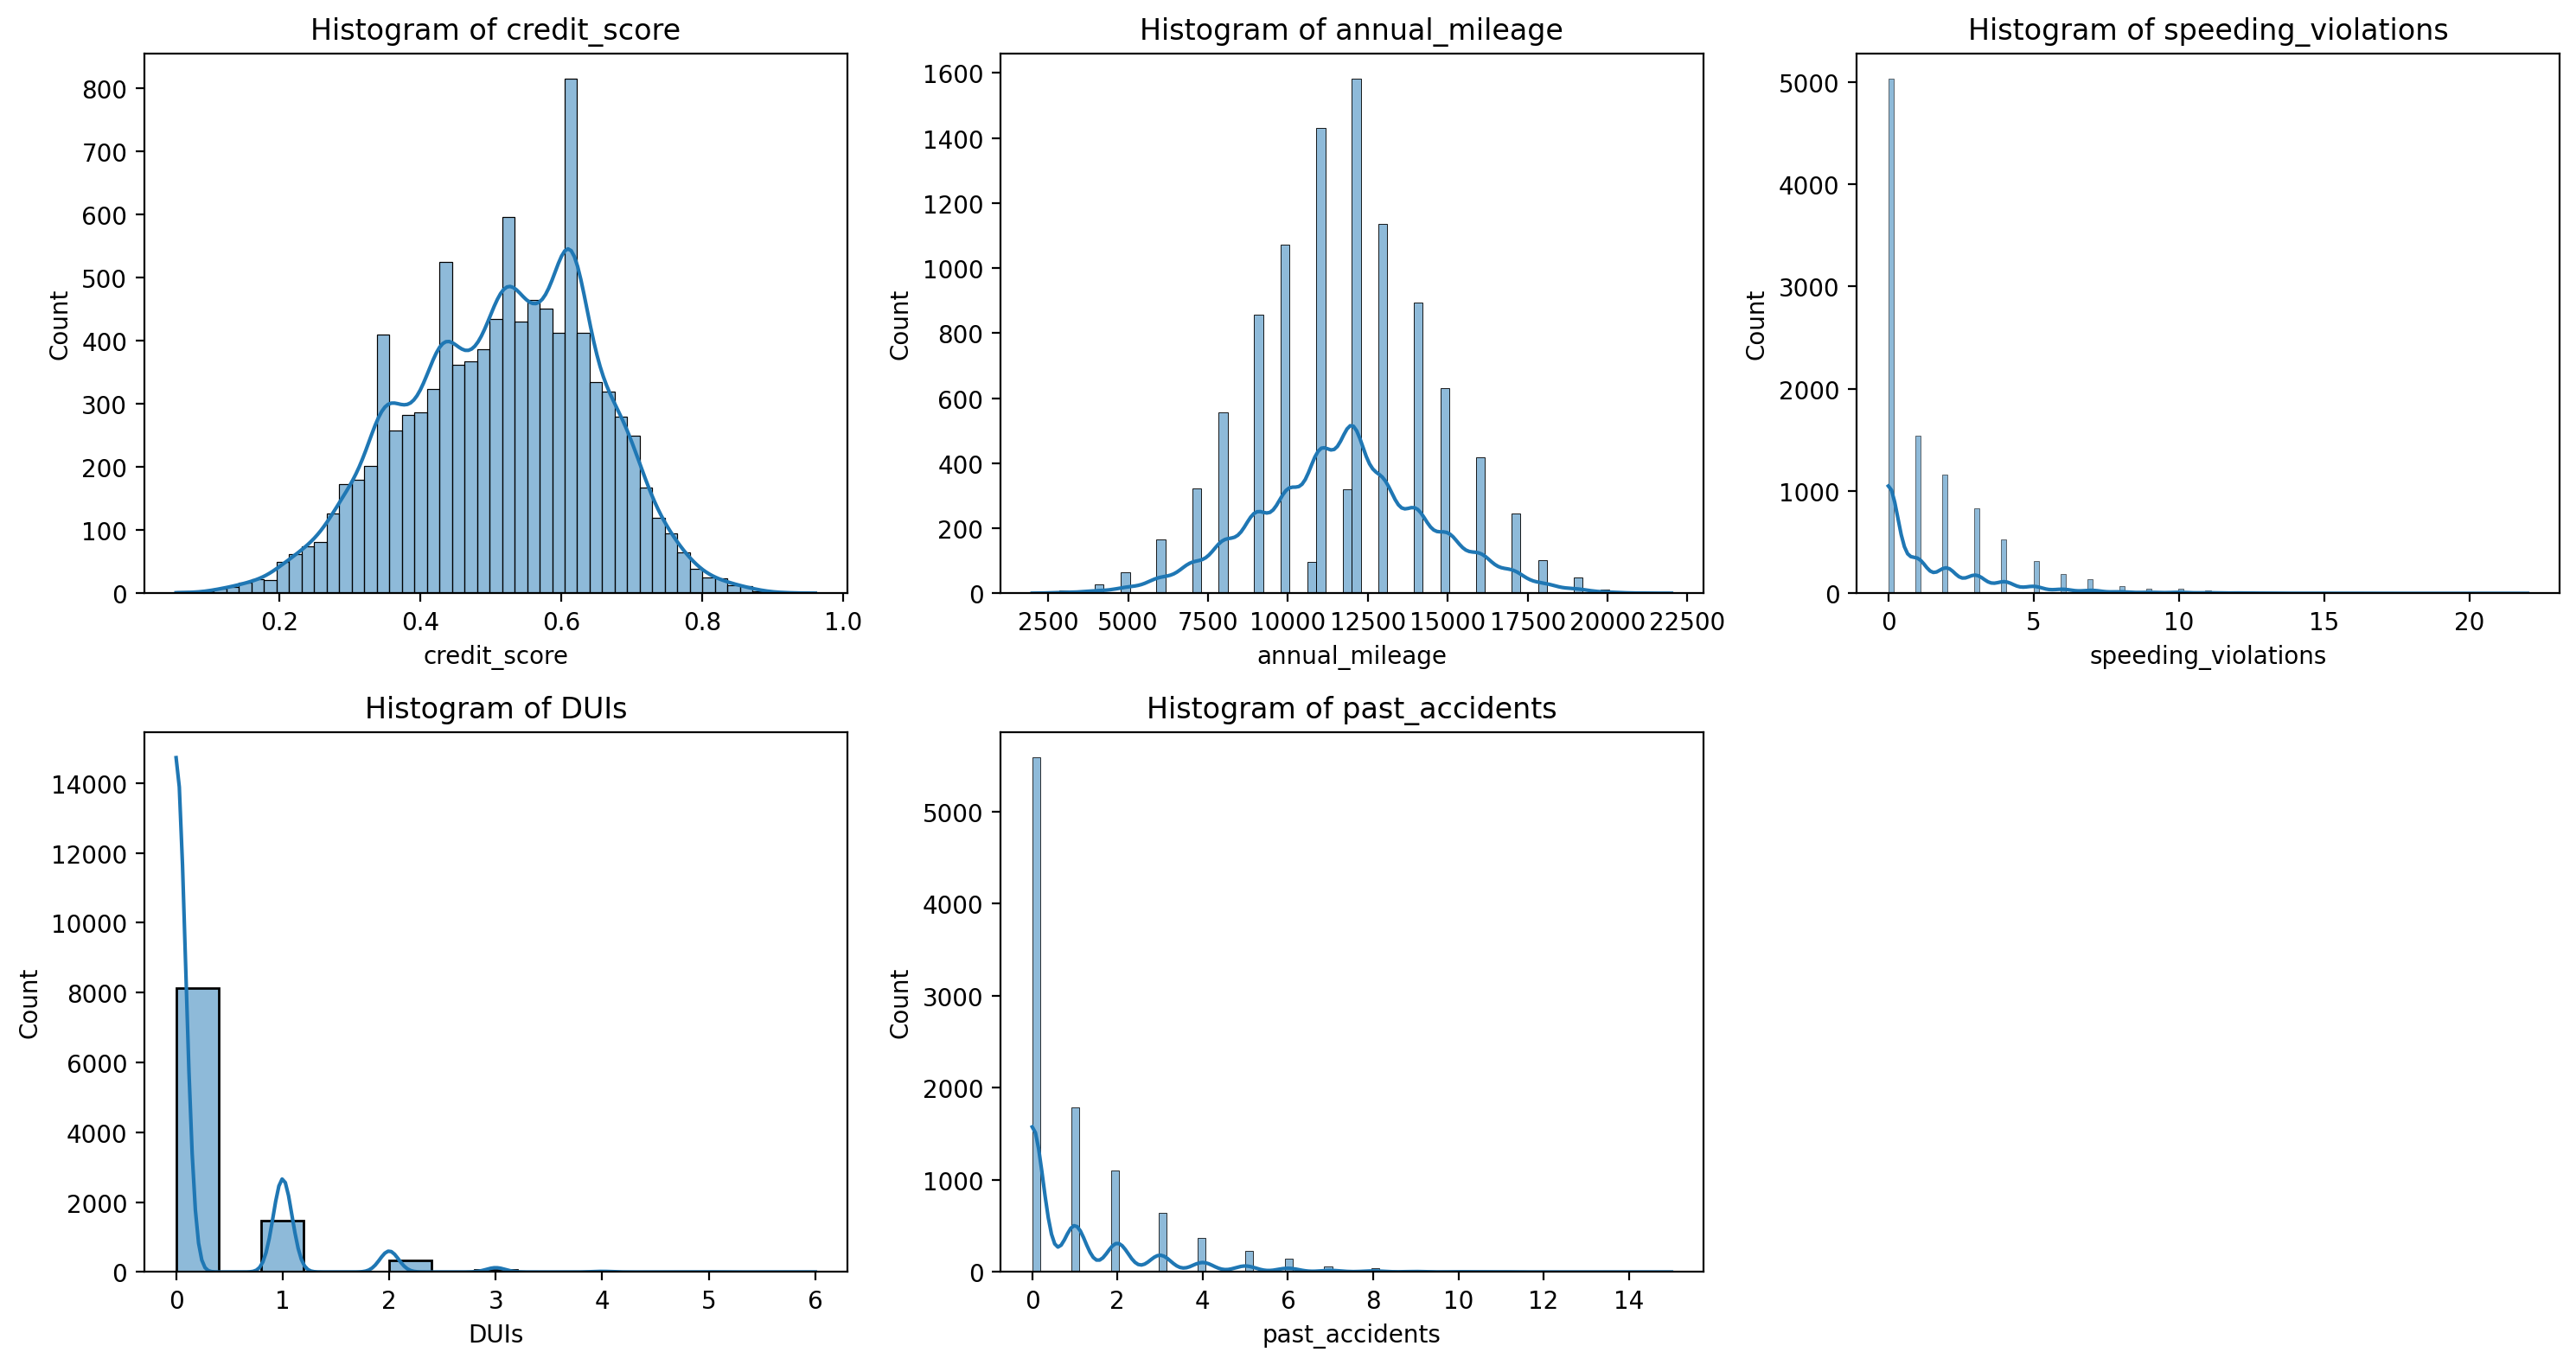

In [205]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=200)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f"Histogram of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

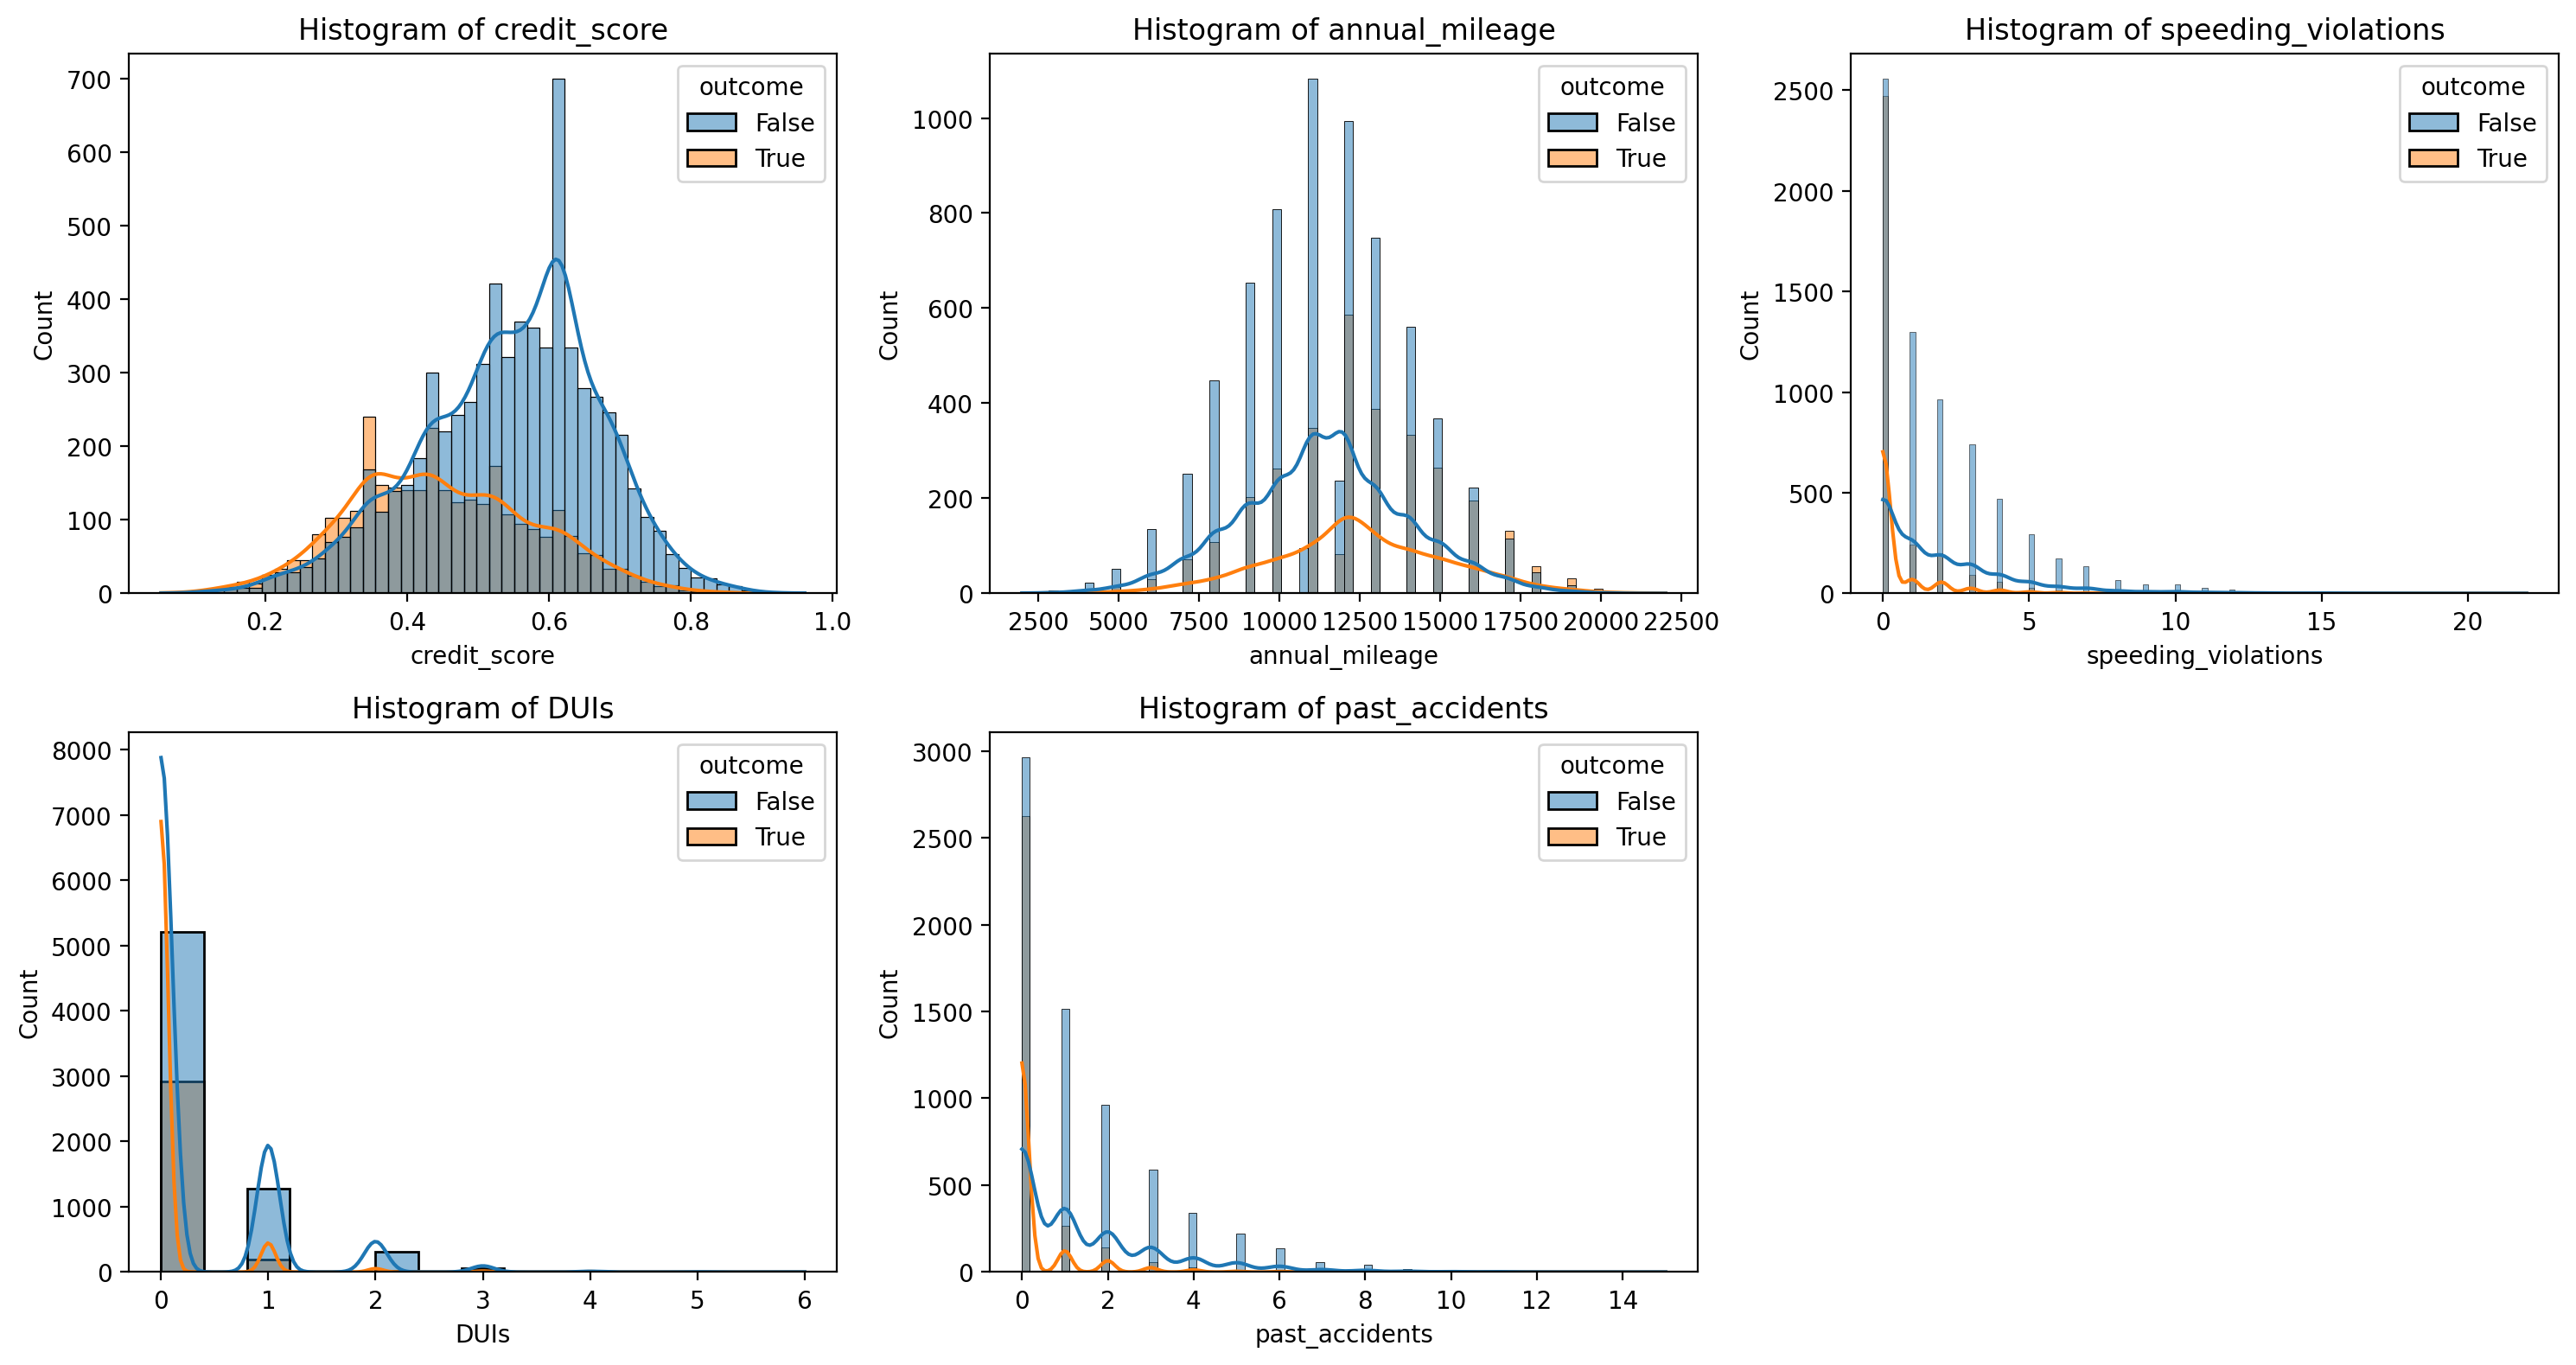

In [206]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=200)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], hue="outcome")
    axes[i].set_title(f"Histogram of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

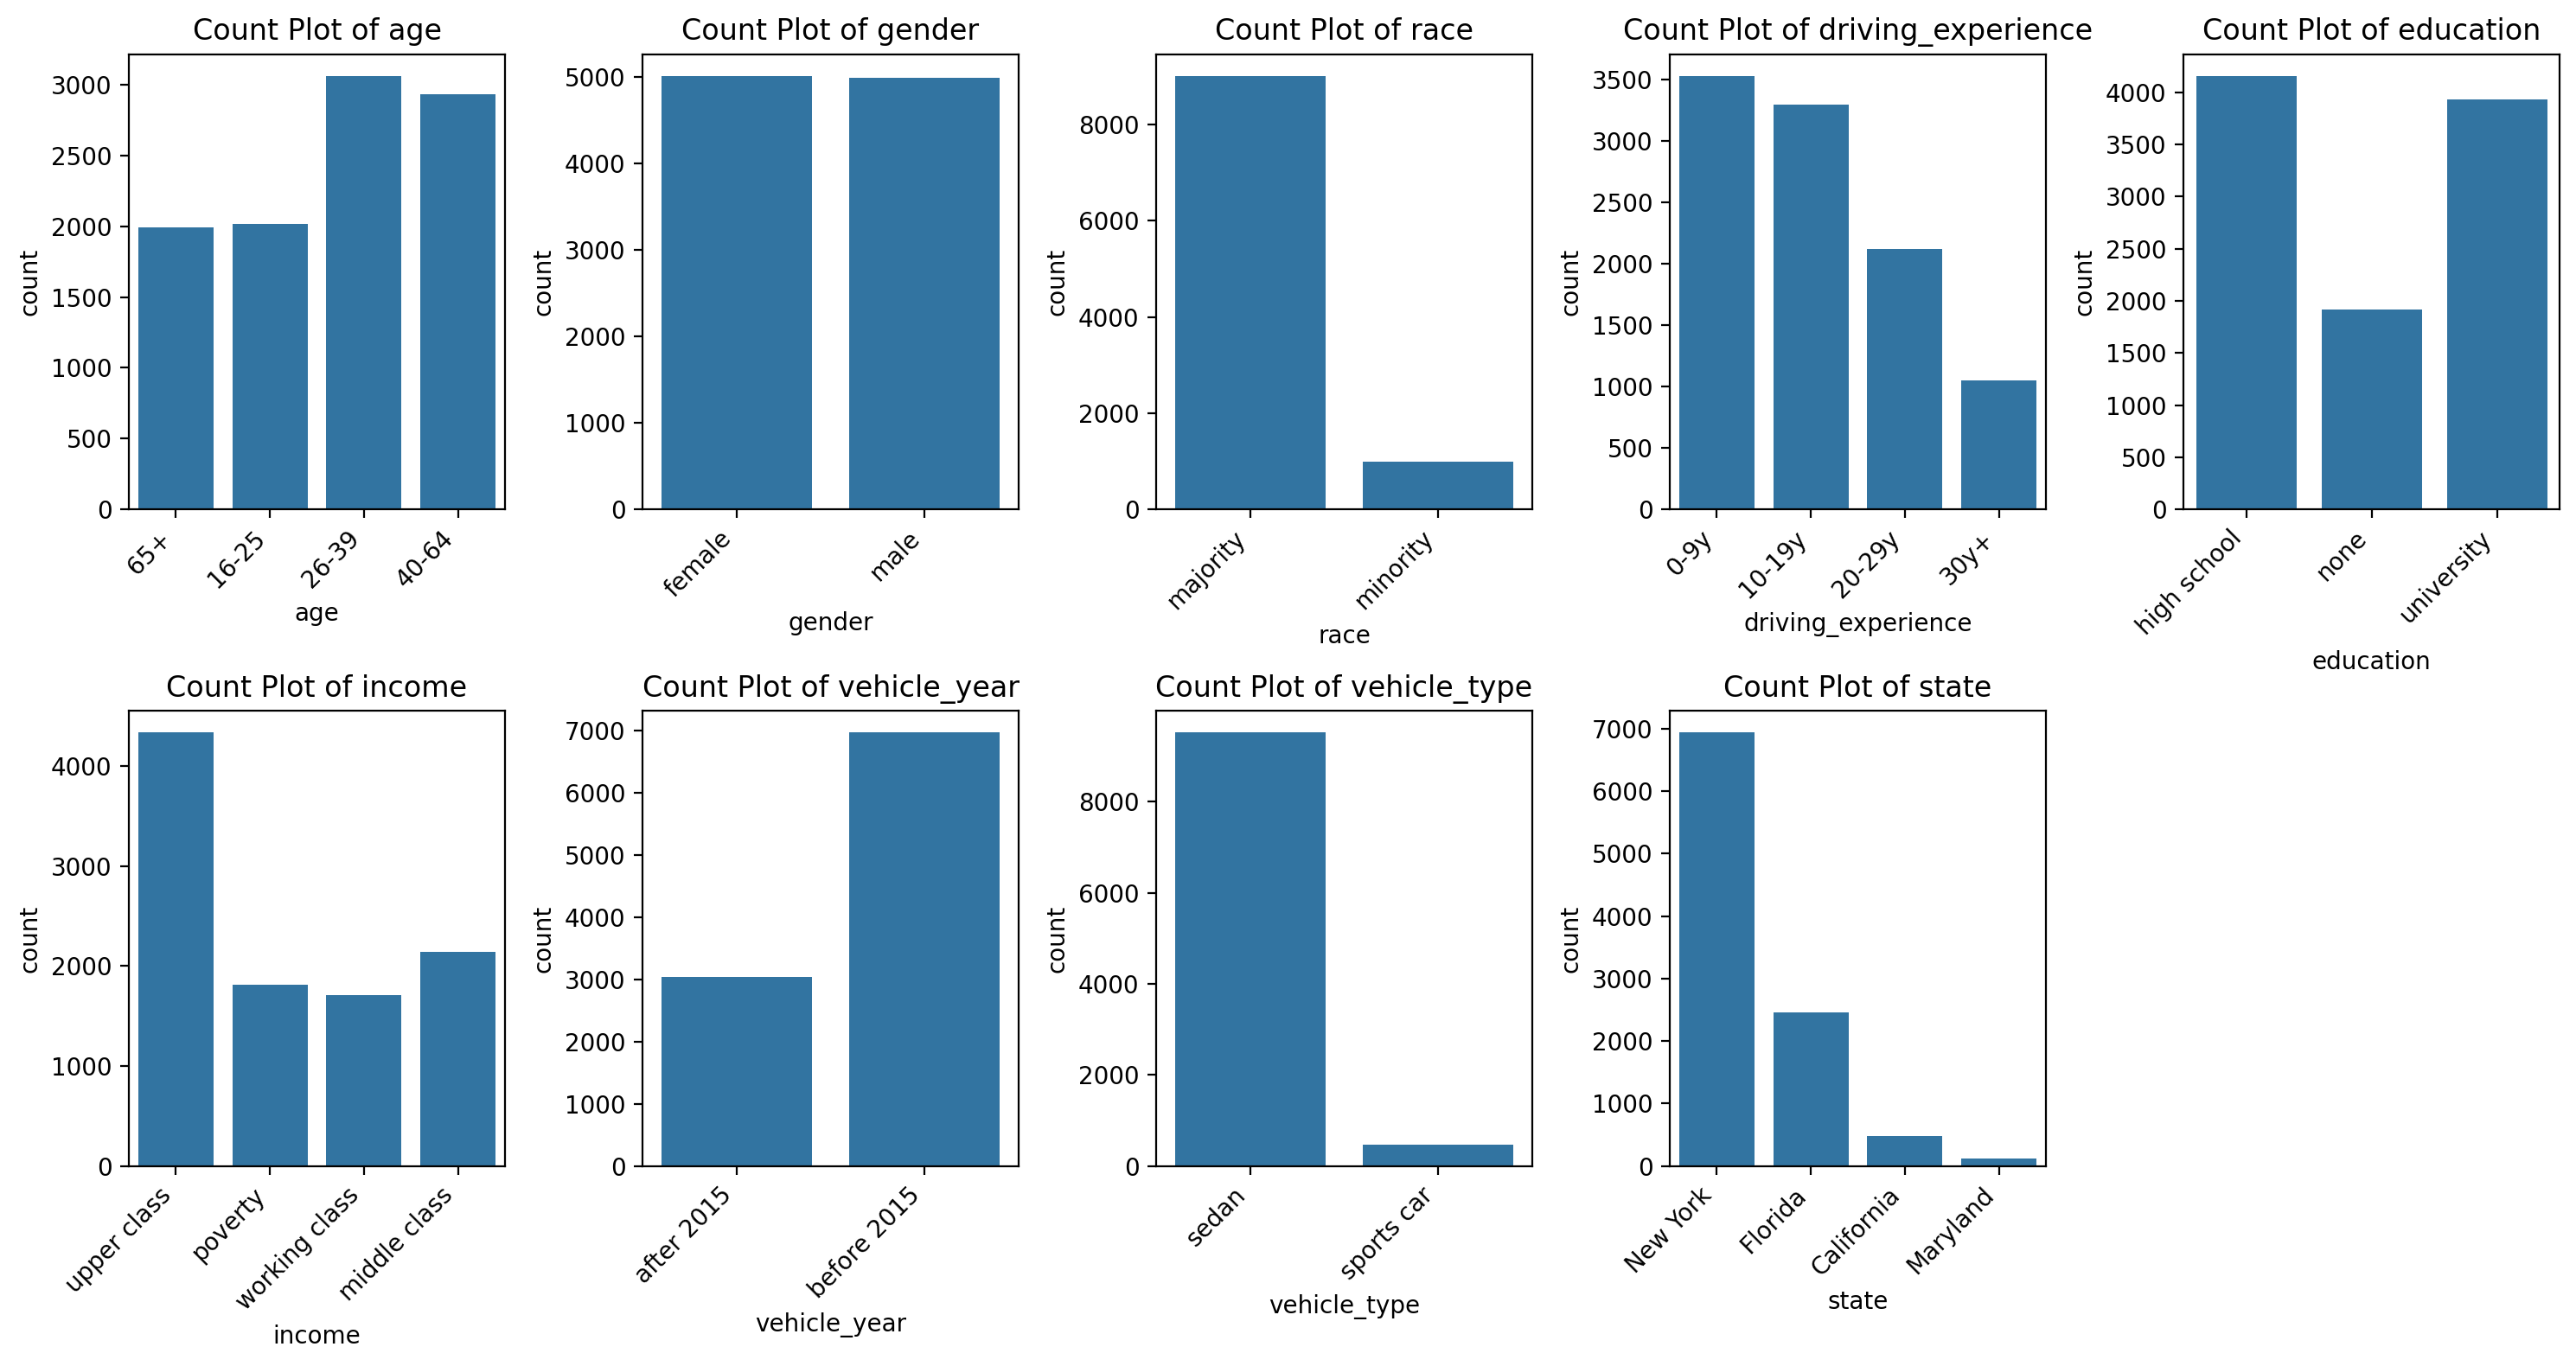

In [207]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), dpi=200)
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Count Plot of {col}")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

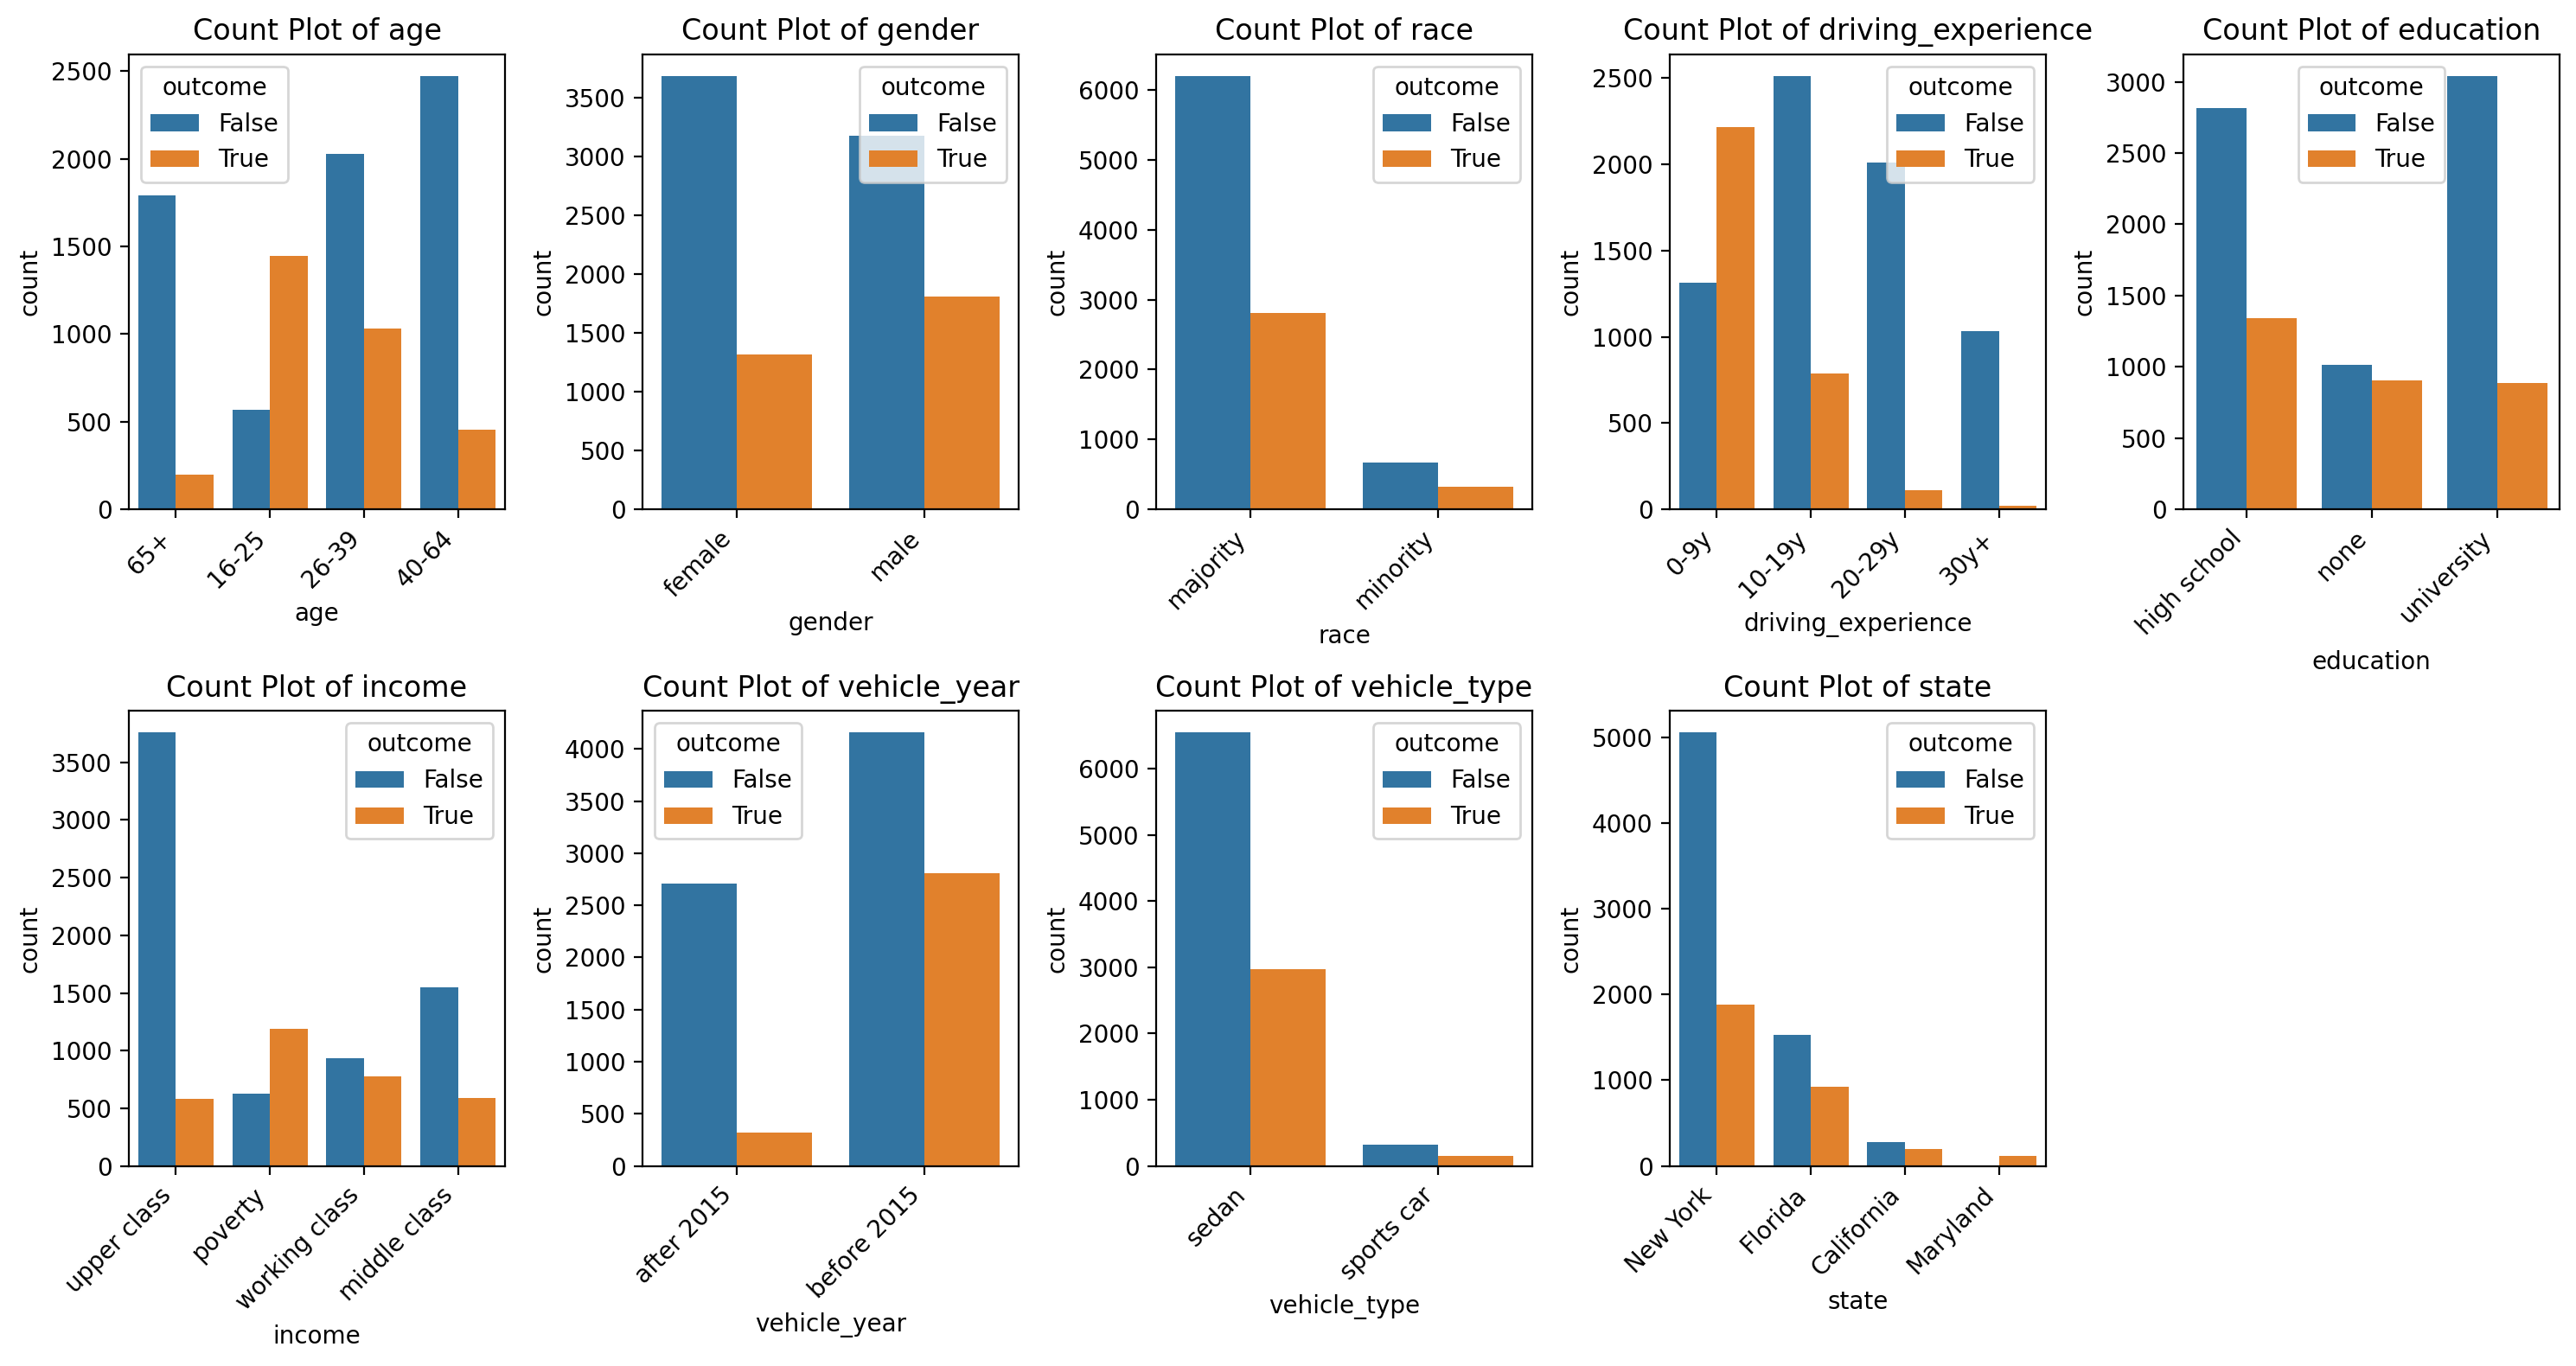

In [208]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), dpi=200)
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i], hue="outcome")
    axes[i].set_title(f"Count Plot of {col}")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Encoding

In [209]:
ordinal_columns = ["age", "driving_experience", "education", "income", "vehicle_year"]
ordinal_categories = [
    ["16-25", "26-39", "40-64", "65+"],
    ["0-9y", "10-19y", "20-29y", "30y+"],
    ["none", "high school", "university"],
    ["poverty", "working class", "middle class", "upper class"],
    ["before 2015", "after 2015"]
]

encoder = OrdinalEncoder(categories=ordinal_categories)
df[ordinal_columns] = encoder.fit_transform(df[ordinal_columns])
df.head()

age  gender      race  driving_experience  education  income  credit_score  \
0  3.0  female  majority                 0.0        1.0     3.0      0.629027   
1  0.0    male  majority                 0.0        0.0     0.0      0.357757   
2  0.0  female  majority                 0.0        1.0     1.0      0.493146   
3  0.0    male  majority                 0.0        2.0     1.0      0.206013   
4  1.0    male  majority                 1.0        0.0     1.0      0.388366   

   vehicle_ownership  vehicle_year  married  children  annual_mileage  \
0               True           1.0    False      True         12000.0   
1              False           0.0    False     False         16000.0   
2               True           0.0    False     False         11000.0   
3               True           0.0    False      True         11000.0   
4               True           0.0    False     False         12000.0   

  vehicle_type  speeding_violations  DUIs  past_accidents  outcome     state  
0        sedan                    0     0               0    False  New York  
1        sedan                    0     0               0     True  New York  
2        sedan                    0     0               0    False  New York  
3        sedan                    0     0               0    False   Florida  
4        sedan                    2     0               1     True   Florida

In [210]:
df = pd.get_dummies(df, drop_first=True)
df.head()

age  driving_experience  education  income  credit_score  \
0  3.0                 0.0        1.0     3.0      0.629027   
1  0.0                 0.0        0.0     0.0      0.357757   
2  0.0                 0.0        1.0     1.0      0.493146   
3  0.0                 0.0        2.0     1.0      0.206013   
4  1.0                 1.0        0.0     1.0      0.388366   

   vehicle_ownership  vehicle_year  married  children  annual_mileage  \
0               True           1.0    False      True         12000.0   
1              False           0.0    False     False         16000.0   
2               True           0.0    False     False         11000.0   
3               True           0.0    False      True         11000.0   
4               True           0.0    False     False         12000.0   

   speeding_violations  DUIs  past_accidents  outcome  gender_male  \
0                    0     0               0    False        False   
1                    0     0               0     True         True   
2                    0     0               0    False        False   
3                    0     0               0    False         True   
4                    2     0               1     True         True   

   race_minority  vehicle_type_sports car  state_Florida  state_Maryland  \
0          False                    False          False           False   
1          False                    False          False           False   
2          False                    False          False           False   
3          False                    False           True           False   
4          False                    False           True           False   

   state_New York  
0            True  
1            True  
2            True  
3           False  
4           False

# Modeling

## Train-Test Split

In [211]:
X = df.drop("outcome", axis=1)
y = df["outcome"]

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 19), (8000,), (2000, 19), (2000,))

## Manual

### Training

In [213]:
base_xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="error",
    random_state=42
)

base_xgb_model.fit(
    X_train, 
    y_train, 
    verbose=True
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluation

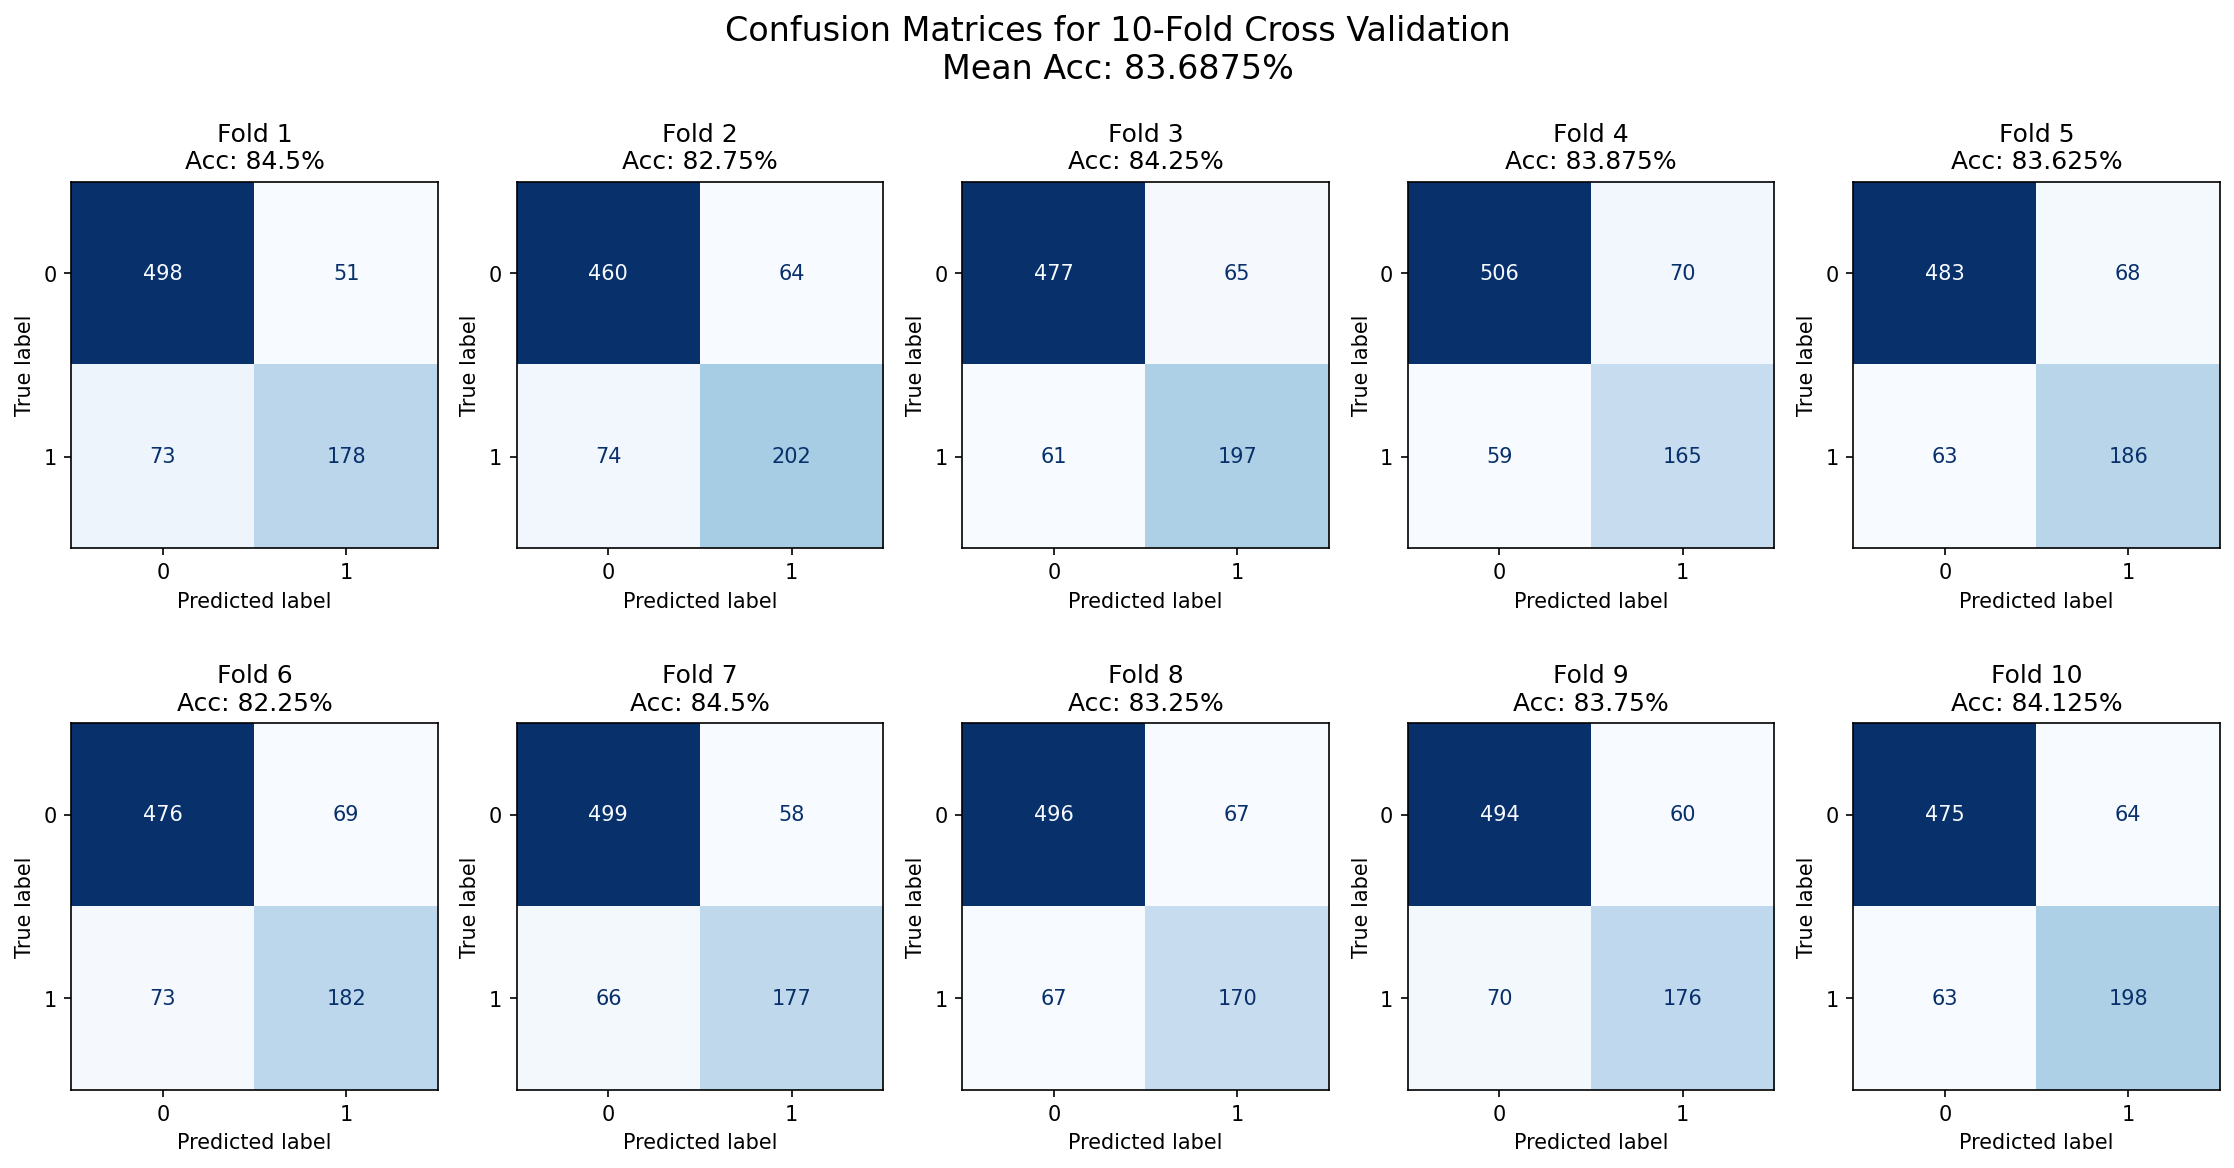

In [217]:
plot_cv_confusion_matrices(
    cross_val_score(base_xgb_model, X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1),
    cross_val_predict(base_xgb_model, X_train, y_train, cv=10, n_jobs=-1),
    y_train,
)

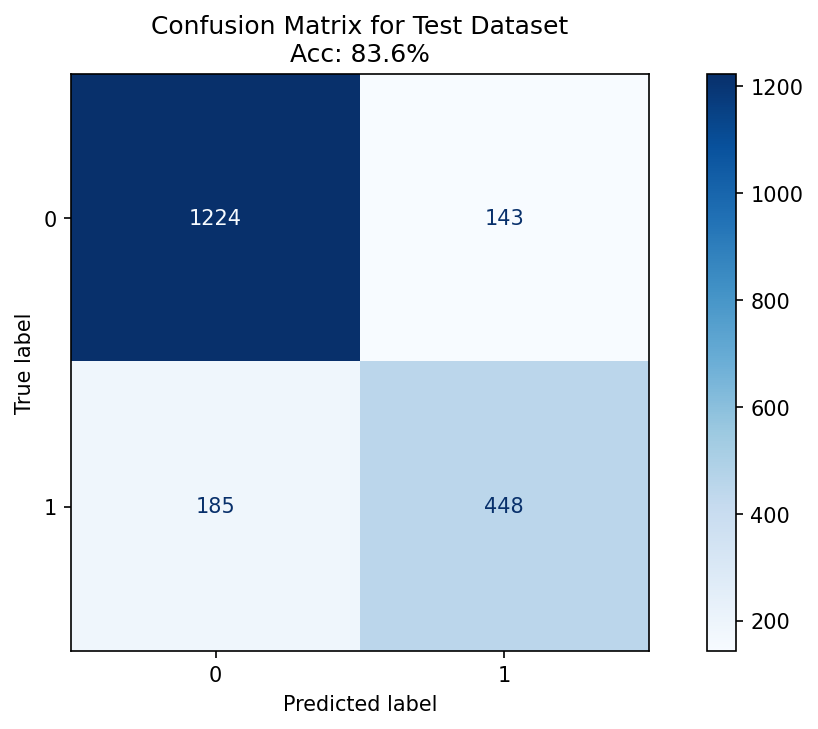

In [58]:
plot_test_confusion_matrix(base_xgb_model, X_test, y_test)

### Feature Selection

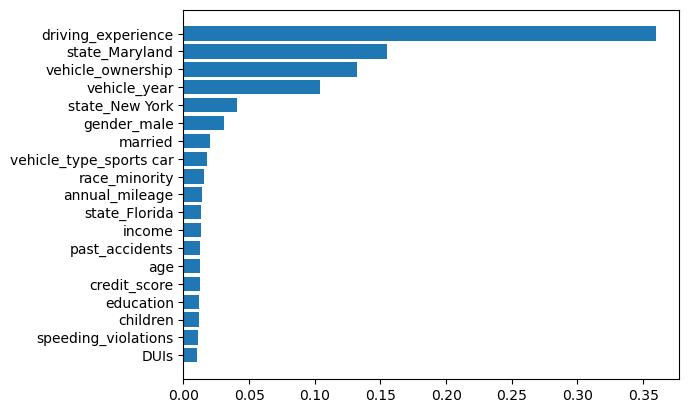

In [59]:
features = base_xgb_model.feature_names_in_
importances = base_xgb_model.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.barh(sorted_features, sorted_importances)
plt.gca().invert_yaxis()
plt.show()

In [60]:
results = {}

for threshold in np.sort(base_xgb_model.feature_importances_):
    selection = SelectFromModel(base_xgb_model, threshold=threshold, prefit=True)
    selected_X_train = selection.transform(X_train)
    selected_X_test = selection.transform(X_test)

    selected_xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        random_state=42
    )
    selected_xgb_model.fit(
        selected_X_train, 
        y_train, 
        verbose=False
    )
    selected_preds = selected_xgb_model.predict(selected_X_test)

    acc = accuracy_score(y_test, selected_preds)

    results[threshold] = {
        'accuracy': acc,
        'features': X.columns[selection.get_support()].tolist()
    }

    print(
        f"Threshold\t: {threshold}\n"
        f"Accuracy\t: {acc*100}%\n"
        f"Features\t: {X.columns[selection.get_support()].tolist()}\n"
    )

Threshold	: 0.010308202356100082
Accuracy	: 83.6%
Features	: ['age', 'driving_experience', 'education', 'income', 'credit_score', 'vehicle_ownership', 'vehicle_year', 'married', 'children', 'annual_mileage', 'speeding_violations', 'DUIs', 'past_accidents', 'gender_male', 'race_minority', 'vehicle_type_sports car', 'state_Florida', 'state_Maryland', 'state_New York']

Threshold	: 0.010714365169405937
Accuracy	: 83.95%
Features	: ['age', 'driving_experience', 'education', 'income', 'credit_score', 'vehicle_ownership', 'vehicle_year', 'married', 'children', 'annual_mileage', 'speeding_violations', 'past_accidents', 'gender_male', 'race_minority', 'vehicle_type_sports car', 'state_Florida', 'state_Maryland', 'state_New York']

Threshold	: 0.011509591713547707
Accuracy	: 83.95%
Features	: ['age', 'driving_experience', 'education', 'income', 'credit_score', 'vehicle_ownership', 'vehicle_year', 'married', 'children', 'annual_mileage', 'past_accidents', 'gender_male', 'race_minority', 'vehicle

In [114]:
selected_features = max(results.items(), key=lambda x: x[1]['accuracy'])[-1]["features"]
selected_features

['driving_experience',
 'vehicle_ownership',
 'vehicle_year',
 'gender_male',
 'state_Maryland',
 'state_New York']

In [115]:
selected_X_train = X_train[selected_features]
selected_X_test = X_test[selected_features]

In [116]:
selected_base_xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="error",
    random_state=42
)

selected_base_xgb_model.fit(
    selected_X_train, 
    y_train, 
    verbose=True
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

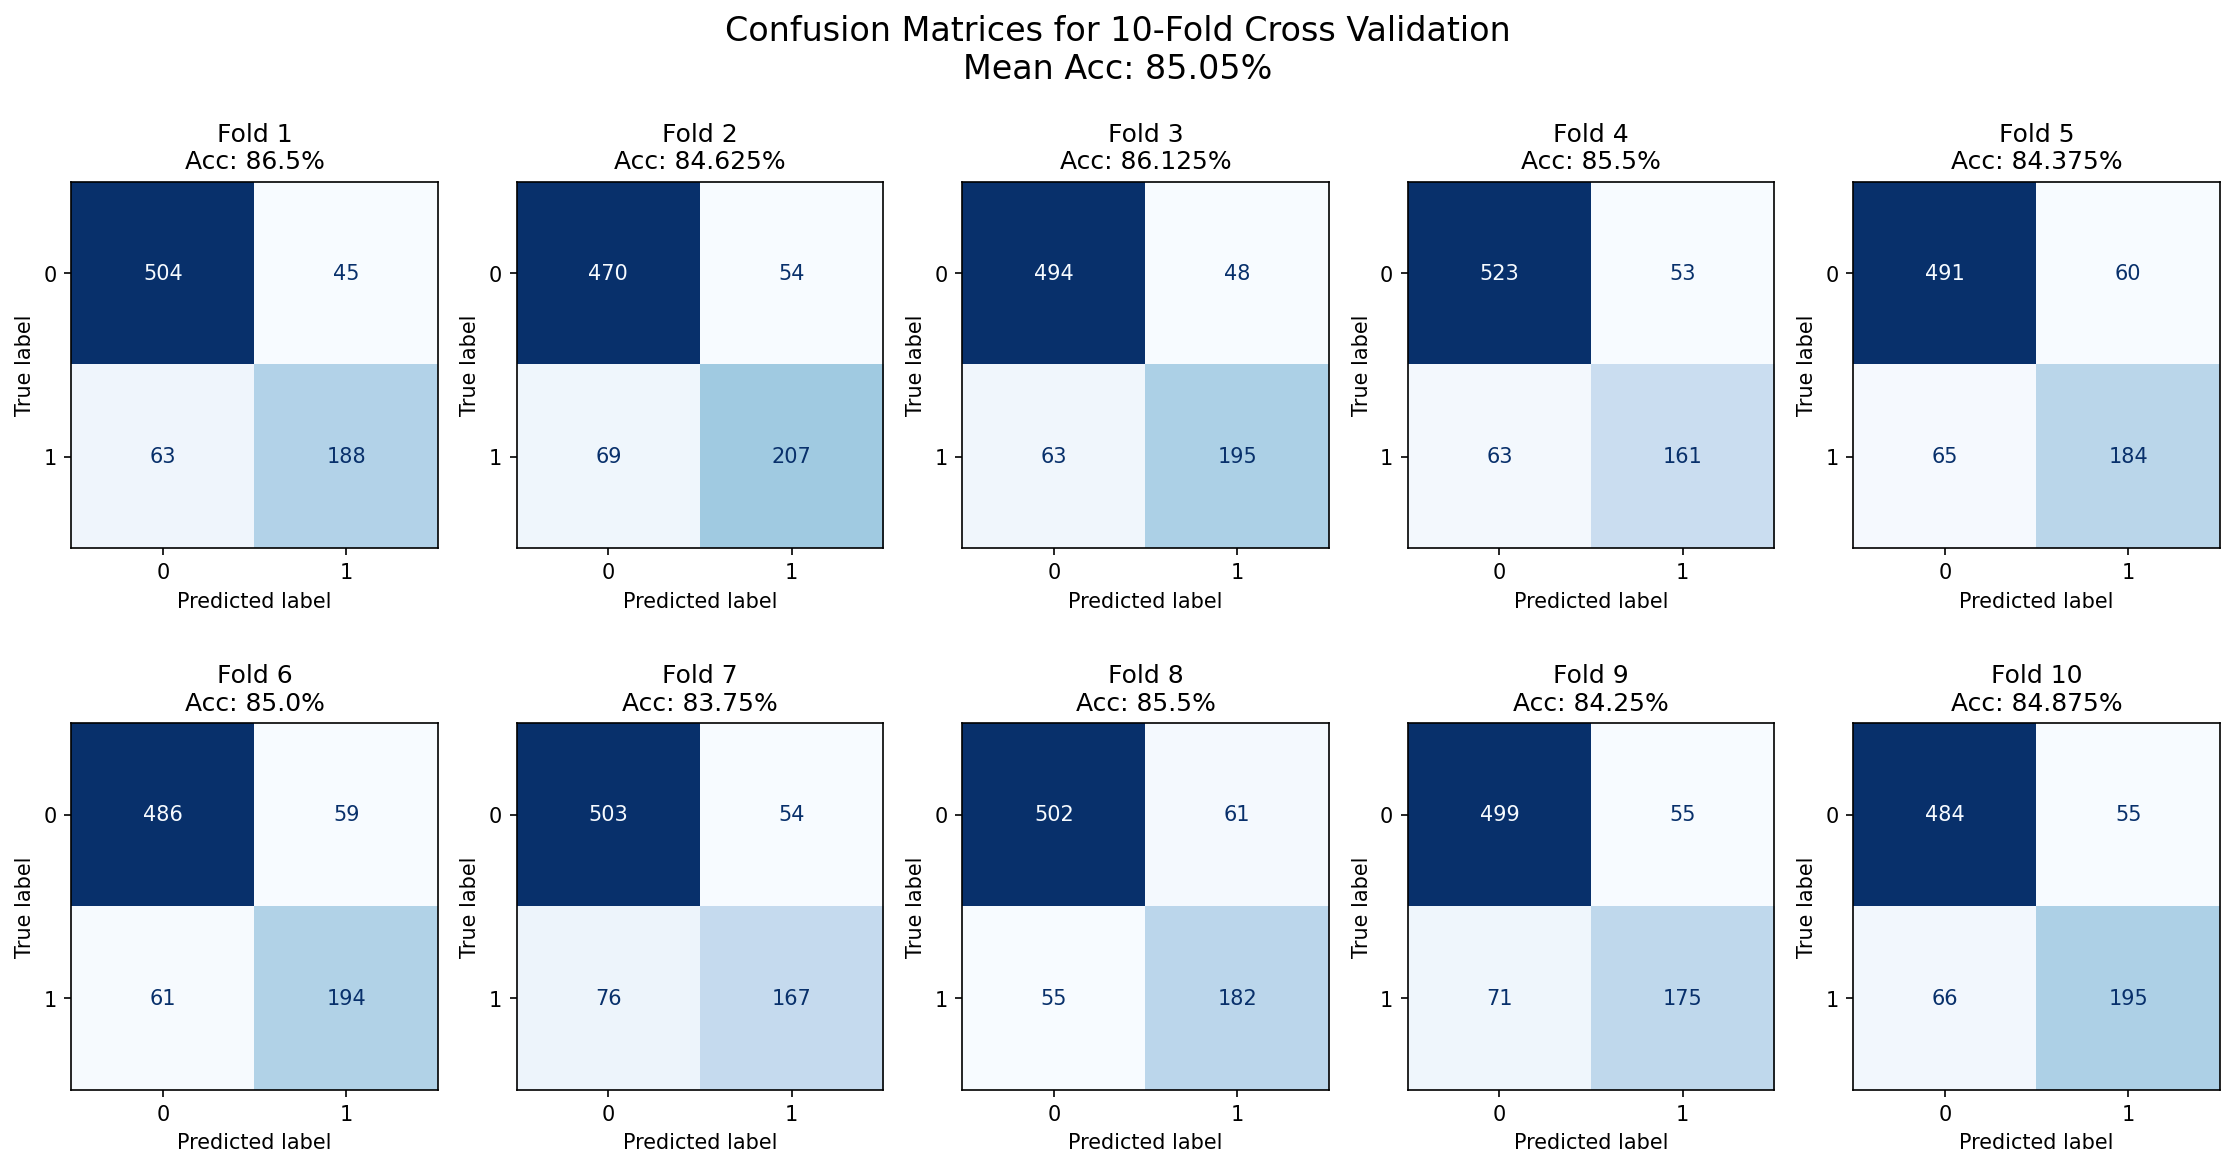

In [117]:
plot_cv_confusion_matrices(
    cross_val_score(selected_base_xgb_model, selected_X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1),
    cross_val_predict(selected_base_xgb_model, selected_X_train, y_train, cv=10, n_jobs=-1),
    y_train
)

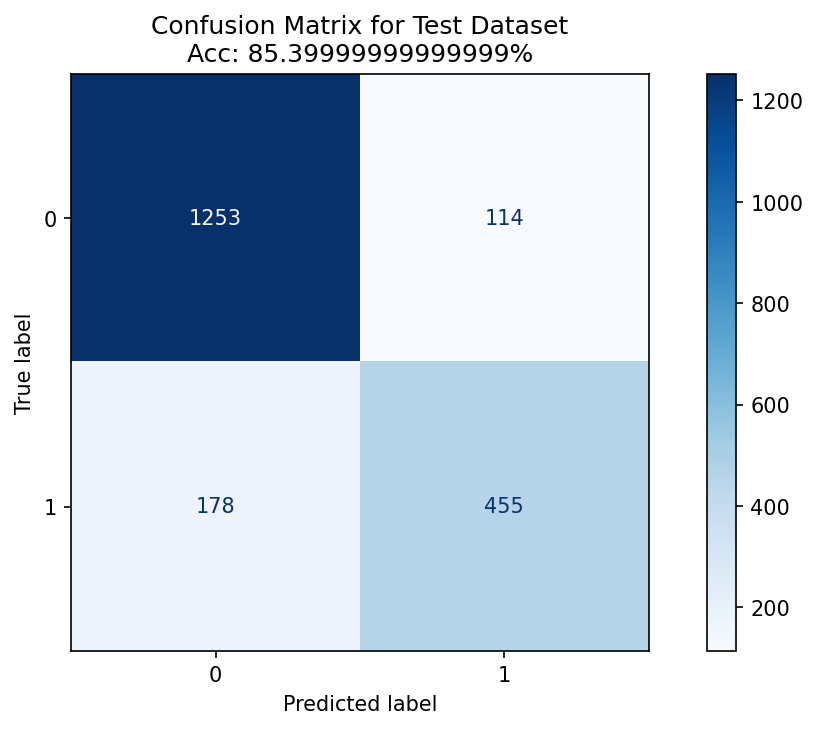

In [118]:
plot_test_confusion_matrix(selected_base_xgb_model, selected_X_test, y_test)

## Optuna

### Training

#### XGBoost

In [123]:
TRAIN = True

if TRAIN:
    opt_xgb_models = []
    opt_xgb_all_accuracies = []
    opt_xgb_mean_accuracies = []
    opt_xgb_cross_val_preds = []

    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "error",
            "random_state": 42,
            "n_estimators": 1000,
            "device": "cuda",
            "verbosity": 0,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        }

        model = xgb.XGBClassifier(**params)

        val_acc = cross_val_score(model, selected_X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
        opt_xgb_all_accuracies.append(val_acc.tolist())

        mean_val_acc = np.mean(val_acc)
        opt_xgb_mean_accuracies.append(mean_val_acc)

        model.fit(selected_X_train, y_train)
        opt_xgb_cross_val_preds.append(model.predict(selected_X_train))
        opt_xgb_models.append(model)

        return mean_val_acc

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
    study.optimize(objective, n_trials=30)

[I 2024-10-03 21:55:32,010] A new study created in memory with name: no-name-38e364d1-82ab-4d0e-abef-69baec548548
[I 2024-10-03 21:55:55,596] Trial 0 finished with value: 0.852 and parameters: {'learning_rate': 0.005611516415334507, 'max_depth': 10, 'subsample': 0.7453942447208348, 'colsample_bytree': 0.6187255599871848, 'min_child_weight': 4}. Best is trial 0 with value: 0.852.
[I 2024-10-03 21:56:08,817] Trial 1 finished with value: 0.7927500000000001 and parameters: {'learning_rate': 0.002051110418843397, 'max_depth': 1, 'subsample': 0.8728673384861885, 'colsample_bytree': 0.6210592611560484, 'min_child_weight': 15}. Best is trial 0 with value: 0.852.
[I 2024-10-03 21:56:26,179] Trial 2 finished with value: 0.689625 and parameters: {'learning_rate': 0.0010994335574766201, 'max_depth': 10, 'subsample': 0.8408205087604007, 'colsample_bytree': 0.25172215514436236, 'min_child_weight': 4}. Best is trial 0 with value: 0.852.
[I 2024-10-03 21:56:48,732] Trial 3 finished with value: 0.81287

#### Other Models: Logistic Regression, Random Forest, LightGBM, and CatBoost

In [129]:
# For Logistic Regression
opt_lr_models = []
opt_lr_all_accuracies = []
opt_lr_mean_accuracies = []
opt_lr_cross_val_preds = []

def objective_lr(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 1e2, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "solver": "liblinear",
        "random_state": 42,
    }

    model = LogisticRegression(**params)

    val_acc = cross_val_score(model, selected_X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
    opt_lr_all_accuracies.append(val_acc.tolist())

    mean_val_acc = np.mean(val_acc)
    opt_lr_mean_accuracies.append(mean_val_acc)

    model.fit(selected_X_train, y_train)
    opt_lr_cross_val_preds.append(model.predict(selected_X_train))
    opt_lr_models.append(model)

    return mean_val_acc

# Logistic Regression study
study_lr = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study_lr.optimize(objective_lr, n_trials=30)

# For Random Forest
opt_rf_models = []
opt_rf_all_accuracies = []
opt_rf_mean_accuracies = []
opt_rf_cross_val_preds = []

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)

    val_acc = cross_val_score(model, selected_X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
    opt_rf_all_accuracies.append(val_acc.tolist())

    mean_val_acc = np.mean(val_acc)
    opt_rf_mean_accuracies.append(mean_val_acc)

    model.fit(selected_X_train, y_train)
    opt_rf_cross_val_preds.append(model.predict(selected_X_train))
    opt_rf_models.append(model)

    return mean_val_acc

# Random Forest study
study_rf = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study_rf.optimize(objective_rf, n_trials=30)

# For LightGBM
opt_lgb_models = []
opt_lgb_all_accuracies = []
opt_lgb_mean_accuracies = []
opt_lgb_cross_val_preds = []

def objective_lgb(trial):
    params = {
        "objective": "binary",
        "metric": "binary_error",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "n_estimators": 1000,
        "random_state": 42,
    }

    model = lgb.LGBMClassifier(**params)

    val_acc = cross_val_score(model, selected_X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
    opt_lgb_all_accuracies.append(val_acc.tolist())

    mean_val_acc = np.mean(val_acc)
    opt_lgb_mean_accuracies.append(mean_val_acc)

    model.fit(selected_X_train, y_train)
    opt_lgb_cross_val_preds.append(model.predict(selected_X_train))
    opt_lgb_models.append(model)

    return mean_val_acc

# LightGBM study
study_lgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=30)

# For CatBoost
opt_cb_models = []
opt_cb_all_accuracies = []
opt_cb_mean_accuracies = []
opt_cb_cross_val_preds = []

def objective_cb(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "Accuracy",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "random_seed": 42,
        "iterations": 1000,
        "verbose": 0
    }

    model = cb.CatBoostClassifier(**params)

    val_acc = cross_val_score(model, selected_X_train, y_train, cv=10, scoring="accuracy", n_jobs=-1)
    opt_cb_all_accuracies.append(val_acc.tolist())

    mean_val_acc = np.mean(val_acc)
    opt_cb_mean_accuracies.append(mean_val_acc)

    model.fit(selected_X_train, y_train)
    opt_cb_cross_val_preds.append(model.predict(selected_X_train))
    opt_cb_models.append(model)

    return mean_val_acc

# CatBoost study
study_cb = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study_cb.optimize(objective_cb, n_trials=30)

[I 2024-10-03 22:11:02,257] A new study created in memory with name: no-name-3e046d23-6aa3-4ee3-ae21-54d3bd6b440a
[I 2024-10-03 22:11:07,186] Trial 0 finished with value: 0.8481250000000001 and parameters: {'C': 0.0745934328572655, 'max_iter': 956}. Best is trial 0 with value: 0.8481250000000001.
[I 2024-10-03 22:11:09,886] Trial 1 finished with value: 0.851875 and parameters: {'C': 4.5705630998014515, 'max_iter': 639}. Best is trial 1 with value: 0.851875.
[I 2024-10-03 22:11:11,605] Trial 2 finished with value: 0.8296250000000001 and parameters: {'C': 0.006026889128682512, 'max_iter': 240}. Best is trial 1 with value: 0.851875.
[I 2024-10-03 22:11:11,639] Trial 3 finished with value: 0.8012499999999999 and parameters: {'C': 0.0019517224641449498, 'max_iter': 880}. Best is trial 1 with value: 0.851875.
[I 2024-10-03 22:11:11,690] Trial 4 finished with value: 0.85175 and parameters: {'C': 1.0129197956845732, 'max_iter': 737}. Best is trial 1 with value: 0.851875.
[I 2024-10-03 22:11:11

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:12:29,066] Trial 1 finished with value: 0.6875 and parameters: {'learning_rate': 0.0013066739238053278, 'max_depth': 9, 'num_leaves': 155, 'subsample': 0.737265320016441, 'colsample_bytree': 0.1185260448662222, 'min_child_weight': 49}. Best is trial 0 with value: 0.817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:12:32,095] Trial 2 finished with value: 0.844125 and parameters: {'learning_rate': 0.04622589001020832, 'max_depth': 3, 'num_leaves': 48, 'subsample': 0.2650640588680905, 'colsample_bytree': 0.373818018663584, 'min_child_weight': 27}. Best is trial 2 with value: 0.844125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:12:34,403] Trial 3 finished with value: 0.842625 and parameters: {'learning_rate': 0.007309539835912915, 'max_depth': 3, 'num_leaves': 158, 'subsample': 0.22554447458683766, 'colsample_bytree': 0.3629301836816964, 'min_child_weight': 19}. Best is trial 2 with value: 0.844125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2024-10-03 22:12:42,640] Trial 4 finished with value: 0.85125 and parameters: {'learning_rate': 0.008168455894760165, 'max_depth': 8, 'num_leaves': 52, 'subsample': 0.5628109945722505, 'colsample_bytree': 0.6331731119758383, 'min_child_weight': 3}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:12:44,713] Trial 5 finished with value: 0.84375 and parameters: {'learning_rate': 0.016409286730647923, 'max_depth': 2, 'num_leaves': 18, 'subsample': 0.9539969835279999, 'colsample_bytree': 0.9690688297671034, 'min_child_weight': 41}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2024-10-03 22:12:45,934] Trial 6 finished with value: 0.8012499999999999 and parameters: {'learning_rate': 0.0040665633135147945, 'max_depth': 1, 'num_leaves': 176, 'subsample': 0.4961372443656412, 'colsample_bytree': 0.20983441136030095, 'min_child_weight': 25}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:12:49,143] Trial 7 finished with value: 0.7855000000000001 and parameters: {'learning_rate': 0.001171593739230706, 'max_depth': 10, 'num_leaves': 67, 'subsample': 0.6962700559185838, 'colsample_bytree': 0.3805399684804699, 'min_child_weight': 27}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:12:51,396] Trial 8 finished with value: 0.843875 and parameters: {'learning_rate': 0.0123999678368461, 'max_depth': 2, 'num_leaves': 249, 'subsample': 0.7976195410250031, 'colsample_bytree': 0.9455490474077702, 'min_child_weight': 45}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:12:55,204] Trial 9 finished with value: 0.8471250000000001 and parameters: {'learning_rate': 0.015696396388661146, 'max_depth': 10, 'num_leaves': 24, 'subsample': 0.27638457617723067, 'colsample_bytree': 0.14070456001948428, 'min_child_weight': 17}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2024-10-03 22:12:57,713] Trial 10 finished with value: 0.833625 and parameters: {'learning_rate': 0.0059890036722543005, 'max_depth': 3, 'num_leaves': 213, 'subsample': 0.4210779940242304, 'colsample_bytree': 0.3528410587186427, 'min_child_weight': 28}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:13:08,866] Trial 11 finished with value: 0.851125 and parameters: {'learning_rate': 0.00191358804876923, 'max_depth': 9, 'num_leaves': 21, 'subsample': 0.9881982429404655, 'colsample_bytree': 0.7950202923669917, 'min_child_weight': 10}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:13:25,277] Trial 12 finished with value: 0.835875 and parameters: {'learning_rate': 0.0010257563974185654, 'max_depth': 9, 'num_leaves': 182, 'subsample': 0.7561064512368886, 'colsample_bytree': 0.7941433120173511, 'min_child_weight': 4}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:13:27,414] Trial 13 finished with value: 0.8407499999999999 and parameters: {'learning_rate': 0.005211124595788265, 'max_depth': 2, 'num_leaves': 222, 'subsample': 0.6609683141448022, 'colsample_bytree': 0.39780822236738433, 'min_child_weight': 4}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:13:33,456] Trial 14 finished with value: 0.842375 and parameters: {'learning_rate': 0.004187594718900628, 'max_depth': 4, 'num_leaves': 188, 'subsample': 0.6738017242196918, 'colsample_bytree': 0.8984914683186939, 'min_child_weight': 24}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-10-03 22:13:45,010] Trial 15 finished with value: 0.843375 and parameters: {'learning_rate': 0.0017345566642360942, 'max_depth': 8, 'num_leaves': 196, 'subsample': 0.6051494778125466, 'colsample_bytree': 0.7938704619591049, 'min_child_weight': 25}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:13:46,810] Trial 16 finished with value: 0.842375 and parameters: {'learning_rate': 0.011103647313054618, 'max_depth': 5, 'num_leaves': 8, 'subsample': 0.19710228429397403, 'colsample_bytree': 0.12828626711806082, 'min_child_weight': 32}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:13:51,136] Trial 17 finished with value: 0.844125 and parameters: {'learning_rate': 0.00425316236379087, 'max_depth': 6, 'num_leaves': 233, 'subsample': 0.32436300623398745, 'colsample_bytree': 0.4693446307320668, 'min_child_weight': 38}. Best is trial 4 with value: 0.85125.
[I 2024-10-03 22:13:52,614] Trial 18 finished with value: 0.79075 and parameters: {'learning_rate': 0.0028681134821030075, 'max_depth': 1, 'num_leaves': 75, 'subsample': 0.24509915852860398, 'colsample_bytree': 0.9367278871083158, 'min_child_weight': 41}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

[I 2024-10-03 22:14:00,759] Trial 19 finished with value: 0.843375 and parameters: {'learning_rate': 0.018484491720988625, 'max_depth': 9, 'num_leaves': 206, 'subsample': 0.2679130529974323, 'colsample_bytree': 0.90330309864098, 'min_child_weight': 27}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:14:03,480] Trial 20 finished with value: 0.844125 and parameters: {'learning_rate': 0.04119839624605188, 'max_depth': 9, 'num_leaves': 83, 'subsample': 0.19904673207490908, 'colsample_bytree': 0.30514164628774754, 'min_child_weight': 22}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:14:05,609] Trial 21 finished with value: 0.85075 and parameters: {'learning_rate': 0.04325432427964557, 'max_depth': 9, 'num_leaves': 3, 'subsample': 0.5596725723198092, 'colsample_bytree': 0.4756699028339011, 'min_child_weight': 12}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-10-03 22:14:09,942] Trial 22 finished with value: 0.807625 and parameters: {'learning_rate': 0.0017367237151593164, 'max_depth': 4, 'num_leaves': 242, 'subsample': 0.3908826388186797, 'colsample_bytree': 0.5669115595690295, 'min_child_weight': 36}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:14:14,972] Trial 23 finished with value: 0.8471250000000001 and parameters: {'learning_rate': 0.0053365330663796085, 'max_depth': 10, 'num_leaves': 247, 'subsample': 0.3266040662428278, 'colsample_bytree': 0.547523655303147, 'min_child_weight': 16}. Best is trial 4 with value: 0.85125.
[I 2024-10-03 22:14:16,359] Trial 24 finished with value: 0.79625 and parameters: {'learning_rate': 0.003712624179040533, 'max_depth': 1, 'num_leaves': 157, 'subsample': 0.5524111209059753, 'colsample_bytree': 0.14633087612499043, 'min_child_weight': 14}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number 

[I 2024-10-03 22:14:20,113] Trial 25 finished with value: 0.85025 and parameters: {'learning_rate': 0.06554382343546285, 'max_depth': 3, 'num_leaves': 38, 'subsample': 0.5405074842498068, 'colsample_bytree': 0.9870854086995406, 'min_child_weight': 13}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:14:24,492] Trial 26 finished with value: 0.8435 and parameters: {'learning_rate': 0.022093834415066283, 'max_depth': 8, 'num_leaves': 62, 'subsample': 0.7553947137506736, 'colsample_bytree': 0.43100481944732794, 'min_child_weight': 32}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:14:27,642] Trial 27 finished with value: 0.851 and parameters: {'learning_rate': 0.018495216589727265, 'max_depth': 6, 'num_leaves': 25, 'subsample': 0.8517722460303142, 'colsample_bytree': 0.3887020584745623, 'min_child_weight': 10}. Best is trial 4 with value: 0.85125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-03 22:14:32,525] Trial 28 finished with value: 0.8092499999999999 and parameters: {'learning_rate': 0.0012065637774378937, 'max_depth': 6, 'num_leaves': 174, 'subsample': 0.11492904603507054, 'colsample_bytree': 0.5608837524693528, 'min_child_weight': 12}. Best is trial 4 with value: 0.85125.
[I 2024-10-03 22:14:34,575] Trial 29 finished with value: 0.852 and parameters: {'learning_rate': 0.01951396765593446, 'max_depth': 2, 'num_leaves': 178, 'subsample': 0.44806181167048365, 'colsample_bytree': 0.9430569898630611, 'min_child_weight': 7}. Best is trial 29 with value: 0.852.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2500, number of negative: 5500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312500 -> initscore=-0.788457
[LightGBM] [Info] Start training from score -0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-10-03 22:14:34,575] A new study created in memory with name: no-name-95bbe397-84d6-437a-9f56-5a71b8a29e61
[W 2024-10-03 22:14:42,391] Trial 0 failed with parameters: {'learning_rate': 0.005611516415334507, 'depth': 10, 'subsample': 0.7587945476302645} because of the following error: The value nan is not acceptable.
[W 2024-10-03 22:14:42,391] Trial 0 failed with value nan.
[I 2024-10-03 22:14:47,408] Trial 1 finished with value: 0.852 and parameters: {'learning_rate': 0.015751320499779727, 'depth': 2, 'subsample': 0.2403950683025824}. Best is trial 1 with value: 0.852.
[I 2024-10-03 22:14:54,754] Trial 2 finished with value: 0.8501249999999999 and parameters: {'learning_rate': 0.0013066739238053278, 'depth': 9, 'subsample': 0.6410035105688879}. Best is trial 1 with value: 0.852.
[I 2024-10-03 22:14:59,124] Trial 3 finished with value: 0.852 and parameters: {'learning_rate': 0.02607024758370768, 'depth': 1, 'subsample': 0.9729188669457949}. Best is trial 1 with value: 0.852.
[I 

### Evaluation

In [148]:
models_data = [
    (opt_lr_models, opt_lr_mean_accuracies, "Logistic Regression"),
    (opt_rf_models, opt_rf_mean_accuracies, "Random Forest"),
    (opt_xgb_models, opt_xgb_mean_accuracies, "XGBoost"),
    (opt_lgb_models, opt_lgb_mean_accuracies, "LightGBM"),
    (opt_cb_models, opt_cb_mean_accuracies, "CatBoost")
]

model_dfs = {}

def get_tuned_params(model):
    default_model = type(model)()
    tuned_params = {k: v for k, v in model.get_params().items() if v != default_model.get_params().get(k)}
    return tuned_params

for models, mean_accuracies, model_name in models_data:
    model_data = []

    for i, (model, mean_accuracy) in enumerate(zip(models, mean_accuracies)):
        tuned_hyperparams = get_tuned_params(model) 

        y_pred = model.predict(selected_X_test)
        test_accuracy = accuracy_score(y_test, y_pred)

        model_entry = {**tuned_hyperparams, "mean_val_accuracy": mean_accuracy, "test_accuracy": test_accuracy}
        model_data.append(model_entry)

    model_df = pd.DataFrame(model_data)
    model_df = model_df.sort_values(["test_accuracy", "mean_val_accuracy"], ascending=False, ignore_index=True)
    model_dfs[model_name] = model_df

In [149]:
model_dfs["Logistic Regression"]

C  max_iter  random_state     solver  mean_val_accuracy  \
0   14.528247       291            42  liblinear           0.852000   
1   67.322489       828            42  liblinear           0.852000   
2   70.456836       798            42  liblinear           0.852000   
3   49.830438       906            42  liblinear           0.852000   
4    4.570563       639            42  liblinear           0.851875   
5    2.637334       496            42  liblinear           0.851750   
6    1.012920       737            42  liblinear           0.851750   
7    1.146211       225            42  liblinear           0.851750   
8    0.916374       141            42  liblinear           0.851750   
9    1.090748       253            42  liblinear           0.851750   
10   0.976113       930            42  liblinear           0.851750   
11   0.541441       266            42  liblinear           0.851125   
12   0.190700       807            42  liblinear           0.850250   
13   0.144453       362            42  liblinear           0.848875   
14   0.074593       956            42  liblinear           0.848125   
15   0.036187       568            42  liblinear           0.847000   
16   0.033348       188            42  liblinear           0.846875   
17   0.033206       572            42  liblinear           0.846750   
18   0.028888       430            42  liblinear           0.845875   
19   0.019674       696            42  liblinear           0.843625   
20   0.009963       563            42  liblinear           0.836000   
21   0.006027       240            42  liblinear           0.829625   
22   0.008112       265            42  liblinear           0.830750   
23   0.004076       546            42  liblinear           0.823375   
24   0.002770       276            42  liblinear           0.813625   
25   0.002115       954            42  liblinear           0.802500   
26   0.001952       880            42  liblinear           0.801250   
27   0.001683       393            42  liblinear           0.801250   
28   0.001486       919            42  liblinear           0.790000   
29   0.001267       973            42  liblinear           0.773375   

    test_accuracy  
0          0.8540  
1          0.8540  
2          0.8540  
3          0.8540  
4          0.8540  
5          0.8525  
6          0.8520  
7          0.8520  
8          0.8520  
9          0.8520  
10         0.8520  
11         0.8510  
12         0.8505  
13         0.8505  
14         0.8495  
15         0.8480  
16         0.8480  
17         0.8480  
18         0.8480  
19         0.8425  
20         0.8390  
21         0.8310  
22         0.8295  
23         0.8220  
24         0.8220  
25         0.7975  
26         0.7975  
27         0.7945  
28         0.7945  
29         0.7830

In [150]:
model_dfs["Random Forest"]

max_depth  min_samples_leaf  min_samples_split  n_estimators  n_jobs  \
0          32                 4               16.0           167      -1   
1           8                 4                5.0           850      -1   
2          18                 6               10.0           374      -1   
3           6                 8                7.0           651      -1   
4          26                11                5.0           510      -1   
5          22                11                7.0           333      -1   
6           8                 7                NaN           179      -1   
7          10                 8               17.0           450      -1   
8          19                10               16.0           785      -1   
9          15                 3                NaN           570      -1   
10         18                17                4.0           353      -1   
11         27                15               15.0           104      -1   
12         21                11                7.0           128      -1   
13          7                11               18.0           824      -1   
14         31                17               20.0           158      -1   
15         21                 2                8.0           877      -1   
16         31                12               15.0           437      -1   
17         12                13               15.0           380      -1   
18         16                15                4.0           899      -1   
19          9                16                9.0           917      -1   
20          7                16               20.0           592      -1   
21          5                 9               15.0           374      -1   
22          6                18                3.0           240      -1   
23         27                18               14.0           937      -1   
24         17                19                NaN           209      -1   
25         29                19               13.0           946      -1   
26         23                20                NaN           641      -1   
27          4                 3                8.0           794      -1   
28          4                 4                7.0           306      -1   
29          3                 4               13.0           633      -1   

    random_state  mean_val_accuracy  test_accuracy  
0             42           0.852000         0.8540  
1             42           0.851250         0.8540  
2             42           0.851250         0.8540  
3             42           0.851250         0.8540  
4             42           0.851250         0.8540  
5             42           0.851250         0.8540  
6             42           0.851250         0.8540  
7             42           0.851250         0.8540  
8             42           0.851250         0.8540  
9             42           0.851000         0.8540  
10            42           0.850875         0.8540  
11            42           0.850875         0.8540  
12            42           0.850875         0.8540  
13            42           0.850875         0.8540  
14            42           0.850750         0.8540  
15            42           0.850750         0.8540  
16            42           0.850625         0.8540  
17            42           0.850625         0.8540  
18            42           0.850625         0.8540  
19            42           0.850625         0.8540  
20            42           0.850375         0.8540  
21            42           0.845750         0.8540  
22            42           0.850500         0.8530  
23            42           0.850000         0.8530  
24            42           0.848875         0.8530  
25            42           0.848375         0.8530  
26            42           0.848500         0.8500  
27            42           0.843250         0.8465  
28            42           0.843250         0.8465  
29            42           0.833875         0.8375

In [151]:
model_dfs["XGBoost"]

colsample_bytree device eval_metric  learning_rate  max_depth  \
0           0.618726   cuda       error       0.005612         10   
1           0.612794   cuda       error       0.037184          2   
2           0.569375   cuda       error       0.021137          4   
3           0.892852   cuda       error       0.004471          8   
4           0.388916   cuda       error       0.005989          3   
5           0.335834   cuda       error       0.084119          3   
6           0.900086   cuda       error       0.086930          8   
7           0.074148   cuda       error       0.009718          6   
8           0.154549   cuda       error       0.041198          9   
9           0.110380   cuda       error       0.053236          7   
10          0.390542   cuda       error       0.028709          8   
11          0.398044   cuda       error       0.016738          2   
12          0.951441   cuda       error       0.016409          2   
13          0.092966   cuda       error       0.069783          1   
14          0.120823   cuda       error       0.012173          2   
15          0.370734   cuda       error       0.006836          3   
16          0.395448   cuda       error       0.004430          6   
17          0.700021   cuda       error       0.041380          4   
18          0.897931   cuda       error       0.055325          9   
19          0.817714   cuda       error       0.003798          2   
20          0.824688   cuda       error       0.035034          2   
21          0.913854   cuda       error       0.001754          5   
22          0.056605   cuda       error       0.007149          9   
23          0.460348   cuda       error       0.002327          4   
24          0.583213   cuda       error       0.001735          8   
25          0.533142   cuda       error       0.001156          7   
26          0.267358   cuda       error       0.003152          5   
27          0.621059   cuda       error       0.002051          1   
28          0.098905   cuda       error       0.001185          7   
29          0.251722   cuda       error       0.001099         10   

    min_child_weight  missing  n_estimators  random_state  subsample  \
0                  4      NaN          1000            42   0.745394   
1                  1      NaN          1000            42   0.538523   
2                  4      NaN          1000            42   0.544065   
3                 10      NaN          1000            42   0.655680   
4                  6      NaN          1000            42   0.837301   
5                  6      NaN          1000            42   0.522386   
6                 12      NaN          1000            42   0.942524   
7                  3      NaN          1000            42   0.456164   
8                  5      NaN          1000            42   0.352103   
9                  7      NaN          1000            42   0.364353   
10                 3      NaN          1000            42   0.120342   
11                10      NaN          1000            42   0.327537   
12                20      NaN          1000            42   0.111799   
13                 7      NaN          1000            42   0.236184   
14                20      NaN          1000            42   0.812087   
15                19      NaN          1000            42   0.163872   
16                20      NaN          1000            42   0.717868   
17                 9      NaN          1000            42   0.142789   
18                11      NaN          1000            42   0.227242   
19                13      NaN          1000            42   0.933213   
20                15      NaN          1000            42   0.055246   
21                 6      NaN          1000            42   0.082669   
22                11      NaN          1000            42   0.867694   
23                 6      NaN          1000            42   0.548519   
24                16      NaN          1000            42   0.77

In [152]:
model_dfs["LightGBM"]

colsample_bytree  learning_rate  max_depth  min_child_weight  \
0           0.943057       0.019514          2                 7   
1           0.633173       0.008168          8                 3   
2           0.795020       0.001914          9                10   
3           0.388702       0.018495          6                10   
4           0.475670       0.043254          9                12   
5           0.987085       0.065544          3                13   
6           0.140705       0.015696         10                17   
7           0.547524       0.005337         10                16   
8           0.362930       0.007310          3                19   
9           0.469345       0.004253          6                38   
10          0.945549       0.012400          2                45   
11          0.969069       0.016409          2                41   
12          0.431005       0.022094          8                32   
13          0.793870       0.001735          8                25   
14          0.903303       0.018484          9                27   
15          0.898491       0.004188          4                24   
16          0.128286       0.011104          5                32   
17          0.397808       0.005211          2                 4   
18          0.373818       0.046226          3                27   
19          0.305142       0.041198          9                22   
20          0.352841       0.005989          3                28   
21          0.794143       0.001026          9                 4   
22          0.240417       0.005612         10                 8   
23          0.560884       0.001207          6                12   
24          0.566912       0.001737          4                36   
25          0.209834       0.004067          1                25   
26          0.146331       0.003713          1                14   
27          0.936728       0.002868          1                41   
28          0.380540       0.001172         10                27   
29          0.118526       0.001307          9                49   

    n_estimators  num_leaves objective  random_state  subsample        metric  \
0           1000         178    binary            42   0.448062  binary_error   
1           1000          52    binary            42   0.562811  binary_error   
2           1000          21    binary            42   0.988198  binary_error   
3           1000          25    binary            42   0.851772  binary_error   
4           1000           3    binary            42   0.559673  binary_error   
5           1000          38    binary            42   0.540507  binary_error   
6           1000          24    binary            42   0.276385  binary_error   
7           1000         247    binary            42   0.326604  binary_error   
8           1000         158    binary            42   0.225544  binary_error   
9           1000         233    binary            42   0.324363  binary_error   
10          1000         249    binary            42   0.797620  binary_error   
11          1000          18    binary            42   0.953997  binary_error   
12          1000          62    binary            42   0.755395  binary_error   
13          1000         196    binary            42   0.605149  binary_error   
14          1000         206    binary            42   0.267913  binary_error   
15          1000         188    binary            42   0.673802  binary_error   
16          1000           8    binary            42   0.197102  binary_error   
17          1000         222    binary            42   0.660968  binary_error   
18          1000          48    binary            42   0.265064  binary_error   
19          1000          83    binary            42   0.199047  binary_error   
20          1000         213    binary            42   0.421078  binary_error   
21          1000         182    binary            42   0.756106  binary_error   
22          1000         188    

In [153]:
model_dfs["CatBoost"]

iterations  learning_rate  depth loss_function  random_seed  verbose  \
0         1000       0.015751      2       Logloss           42        0   
1         1000       0.026070      1       Logloss           42        0   
2         1000       0.007310      3       Logloss           42        0   
3         1000       0.016409      2       Logloss           42        0   
4         1000       0.007591      2       Logloss           42        0   
5         1000       0.012400      2       Logloss           42        0   
6         1000       0.005989      3       Logloss           42        0   
7         1000       0.005170      3       Logloss           42        0   
8         1000       0.005211      2       Logloss           42        0   
9         1000       0.046226      3       Logloss           42        0   
10        1000       0.021137      4       Logloss           42        0   
11        1000       0.004188      4       Logloss           42        0   
12        1000       0.008168      8       Logloss           42        0   
13        1000       0.035503     10       Logloss           42        0   
14        1000       0.001914      9       Logloss           42        0   
15        1000       0.017644      4       Logloss           42        0   
16        1000       0.079026     10       Logloss           42        0   
17        1000       0.010677      6       Logloss           42        0   
18        1000       0.015696     10       Logloss           42        0   
19        1000       0.094140      8       Logloss           42        0   
20        1000       0.028709      8       Logloss           42        0   
21        1000       0.018841      9       Logloss           42        0   
22        1000       0.001307      9       Logloss           42        0   
23        1000       0.001172     10       Logloss           42        0   
24        1000       0.001026      9       Logloss           42        0   
25        1000       0.005612     10       Logloss           42        0   
26        1000       0.002327      4       Logloss           42        0   
27        1000       0.001901      3       Logloss           42        0   
28        1000       0.004067      1       Logloss           42        0   
29        1000       0.002466      1       Logloss           42        0   

   eval_metric  subsample  mean_val_accuracy  test_accuracy  
0     Accuracy   0.240395           0.852000         0.8540  
1     Accuracy   0.972919           0.852000         0.8540  
2     Accuracy   0.650668           0.852000         0.8540  
3     Accuracy   0.158546           0.852000         0.8540  
4     Accuracy   0.545659           0.852000         0.8540  
5     Accuracy   0.972626           0.852000         0.8540  
6     Accuracy   0.845864           0.852000         0.8540  
7     Accuracy   0.588426           0.852000         0.8540  
8     Accuracy   0.876793           0.851500         0.8540  
9     Accuracy   0.263642           0.851000         0.8540  
10    Accuracy   0.568061           0.851000         0.8540  
11    Accuracy   0.756646           0.851000         0.8540  
12    Accuracy   0.279706           0.850750         0.8540  
13    Accuracy   0.905345           0.850750         0.8540  
14    Accuracy   0.167096           0.850750         0.8540  
15    Accuracy   0.157203           0.850750         0.8540  
16    Accuracy   0.827558           0.850625         0.8540  
17    Accuracy   0.141805           0.850500         0.8540  
18    Accuracy   0.179643           0.850500         0.8540  
19    Accuracy   0.278844           0.850500         0.8540  
20    Accuracy   0.166640           0.850500         0.8540  
21    Accuracy   0.524993           0.850500         0.8540  
22    Accuracy   0.641004           0.850125         0.8540  
23    Accuracy   0.332902           0.850125         0.8540  
24    Accuracy   0.736172           0.850125         0.8540  
25    Accuracy   0.758795          

In [196]:
pd.concat(model_dfs, axis=1)

Logistic Regression                                                     \
                     C max_iter random_state     solver mean_val_accuracy   
0            14.528247      291           42  liblinear          0.852000   
1            67.322489      828           42  liblinear          0.852000   
2            70.456836      798           42  liblinear          0.852000   
3            49.830438      906           42  liblinear          0.852000   
4             4.570563      639           42  liblinear          0.851875   
5             2.637334      496           42  liblinear          0.851750   
6             1.012920      737           42  liblinear          0.851750   
7             1.146211      225           42  liblinear          0.851750   
8             0.916374      141           42  liblinear          0.851750   
9             1.090748      253           42  liblinear          0.851750   
10            0.976113      930           42  liblinear          0.851750   
11            0.541441      266           42  liblinear          0.851125   
12            0.190700      807           42  liblinear          0.850250   
13            0.144453      362           42  liblinear          0.848875   
14            0.074593      956           42  liblinear          0.848125   
15            0.036187      568           42  liblinear          0.847000   
16            0.033348      188           42  liblinear          0.846875   
17            0.033206      572           42  liblinear          0.846750   
18            0.028888      430           42  liblinear          0.845875   
19            0.019674      696           42  liblinear          0.843625   
20            0.009963      563           42  liblinear          0.836000   
21            0.006027      240           42  liblinear          0.829625   
22            0.008112      265           42  liblinear          0.830750   
23            0.004076      546           42  liblinear          0.823375   
24            0.002770      276           42  liblinear          0.813625   
25            0.002115      954           42  liblinear          0.802500   
26            0.001952      880           42  liblinear          0.801250   
27            0.001683      393           42  liblinear          0.801250   
28            0.001486      919           42  liblinear          0.790000   
29            0.001267      973           42  liblinear          0.773375   

                 Random Forest                                     \
   test_accuracy     max_depth min_samples_leaf min_samples_split   
0         0.8540            32                4              16.0   
1         0.8540             8                4               5.0   
2         0.8540            18                6              10.0   
3         0.8540             6                8               7.0   
4         0.8540            26               11               5.0   
5         0.8525            22               11               7.0   
6         0.8520             8                7               NaN   
7         0.8520            10                8              17.0   
8         0.8520            19               10              16.0   
9         0.8520            15                3               NaN   
10        0.8520            18               17               4.0   
11        0.8510            27               15              15.0   
12        0.8505            21               11               7.0   
13        0.8505             7               11              18.0   
14        0.8495            31               17              20.0   
15        0.8480            21                2               8.0   
16        0.8480            31               12              15.0   
17        0.8480            12               13              15.0   
18        0.8480            16               15               4.0   
19        0.8425             9               16               9.0   
20        0.8390    

### Stacking

In [162]:
top_rf_models = opt_rf_models[:10]
top_cb_models = opt_cb_models[:10]

base_learners = [
    (f"rf_{i}", model) for i, model in enumerate(top_rf_models)
] + [
    (f"cb_{i}", model) for i, model in enumerate(top_cb_models)
]

meta_learner = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=10,
    n_jobs=-1
)   

stack_model.fit(selected_X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('rf_0',
                                RandomForestClassifier(max_depth=31,
                                                       min_samples_leaf=12,
                                                       min_samples_split=15,
                                                       n_estimators=437,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('rf_1',
                                RandomForestClassifier(max_depth=6,
                                                       min_samples_leaf=18,
                                                       min_samples_split=3,
                                                       n_estimators=240,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('rf_2',
                                RandomForestClassifier(max_depth=23,
                                                       min_samples...
                               ('cb_6',
                                <catboost.core.CatBoostClassifier object at 0x000001292B0AE110>),
                               ('cb_7',
                                <catboost.core.CatBoostClassifier object at 0x000001292B0AF700>),
                               ('cb_8',
                                <catboost.core.CatBoostClassifier object at 0x000001292B0AE440>),
                               ('cb_9',
                                <catboost.core.CatBoostClassifier object at 0x000001292B0AF760>)],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1)

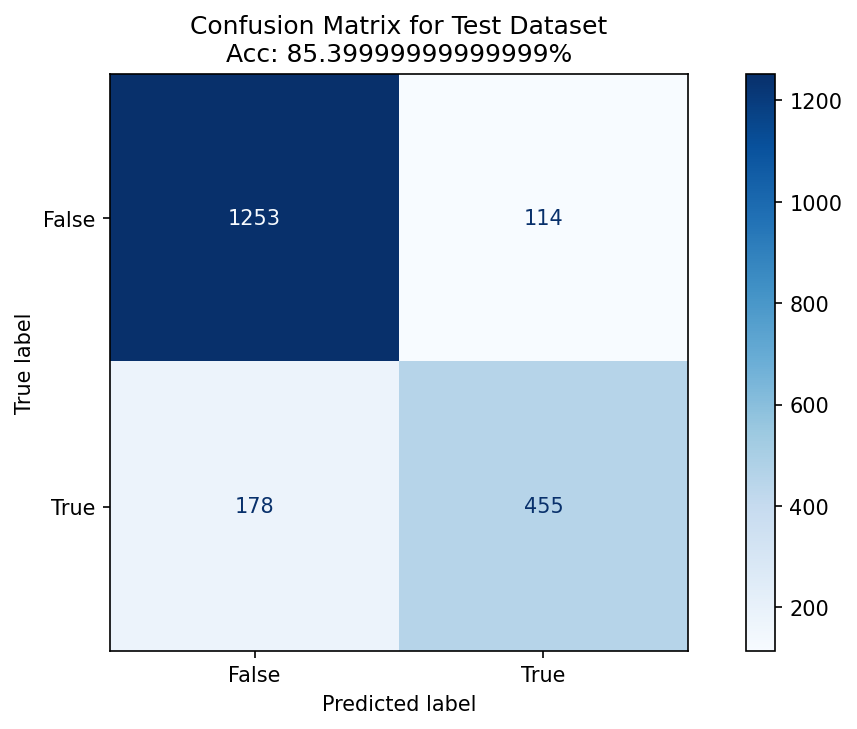

In [163]:
plot_test_confusion_matrix(stack_model, selected_X_test, y_test)

## AutoGluon: Let's Push the Work Laptop to Its Limit

### All Features

In [170]:
train_data = TabularDataset(df.iloc[X_train.index])
train_data.head()

age  driving_experience  education  income  credit_score  \
9254  3.0                 3.0        1.0     3.0      0.545417   
1561  1.0                 0.0        0.0     0.0      0.361876   
1670  1.0                 0.0        2.0     2.0      0.535840   
6087  2.0                 1.0        1.0     3.0      0.612545   
6669  2.0                 0.0        2.0     2.0      0.474268   

      vehicle_ownership  vehicle_year  married  children  annual_mileage  \
9254               True           1.0     True      True          8000.0   
1561              False           0.0     True      True          9000.0   
1670               True           0.0     True     False         12000.0   
6087               True           1.0     True     False          9000.0   
6669               True           0.0    False     False         13000.0   

      speeding_violations  DUIs  past_accidents  outcome  gender_male  \
9254                    4     0               6    False        False   
1561                    0     0               0     True         True   
1670                    0     0               0    False        False   
6087                    3     0               0    False        False   
6669                    0     0               0     True         True   

      race_minority  vehicle_type_sports car  state_Florida  state_Maryland  \
9254          False                    False          False           False   
1561          False                    False          False           False   
1670           True                    False          False           False   
6087          False                    False           True           False   
6669          False                    False           True           False   

      state_New York  
9254            True  
1561            True  
1670            True  
6087           False  
6669           False

In [171]:
test_data = TabularDataset(df.iloc[X_test.index])
test_data_nolab = test_data.drop(columns=["outcome"])
test_data_nolab.head()

age  driving_experience  education  income  credit_score  \
6252  1.0                 1.0        1.0     2.0      0.541596   
4684  3.0                 2.0        1.0     3.0      0.553462   
1731  0.0                 0.0        0.0     0.0      0.245740   
4742  0.0                 0.0        0.0     0.0      0.348331   
4521  2.0                 2.0        2.0     3.0      0.689458   

      vehicle_ownership  vehicle_year  married  children  annual_mileage  \
6252              False           0.0     True      True         11000.0   
4684               True           0.0     True     False          8000.0   
1731              False           0.0    False     False         13000.0   
4742               True           0.0    False     False         14000.0   
4521               True           1.0     True      True         10000.0   

      speeding_violations  DUIs  past_accidents  gender_male  race_minority  \
6252                    1     0               0        False          False   
4684                    3     1               4        False          False   
1731                    0     0               0        False           True   
4742                    0     0               0         True          False   
4521                    2     0               0        False          False   

      vehicle_type_sports car  state_Florida  state_Maryland  state_New York  
6252                    False           True           False           False  
4684                    False          False           False            True  
1731                    False           True           False           False  
4742                    False          False           False            True  
4521                     True          False           False            True

In [172]:
predictor = TabularPredictor(
    label="outcome",
    path="../models/agModels-predictOutcome",
    eval_metric="accuracy"
).fit(
    train_data,
    time_limit=3 * 60 * 60,
    presets="best_quality",
    excluded_model_types=["KNN"]
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          22
Memory Avail:       7.21 GB / 31.47 GB (22.9%)
Disk Space Avail:   604.32 GB / 612.07 GB (98.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up

[1000]	valid_set's binary_error: 0.126126


	0.8577	 = Validation score   (accuracy)
	7.7s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 1316.28s of the 2215.63s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8618	 = Validation score   (accuracy)
	136.93s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 1179.09s of the 2078.44s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8529	 = Validation score   (accuracy)
	9.32s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 1169.2s of the 2068.55s of remaining time.
	0.8321	 = Validation score   (accuracy)
	0.65s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 1168.25s of the 2067.6s of remai

[1000]	valid_set's binary_error: 0.143982
[1000]	valid_set's binary_error: 0.149606
[1000]	valid_set's binary_error: 0.149606
[1000]	valid_set's binary_error: 0.134009


	0.8554	 = Validation score   (accuracy)
	21.9s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 337.62s of the 1236.97s of remaining time.
	0.848	 = Validation score   (accuracy)
	0.76s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 336.61s of the 1235.96s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8613	 = Validation score   (accuracy)
	10.85s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 325.58s of the 1224.93s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 4: early stopping
No improvement since epoch 7: early stopping
No improvement since epoch 9: early stopping
No improvement since epoch 2: early stopping
No improvement 

[1000]	valid_set's binary_error: 0.130484
[1000]	valid_set's binary_error: 0.143982


	0.8678	 = Validation score   (accuracy)
	7.05s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 414.18s of the 414.0s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8649	 = Validation score   (accuracy)
	86.85s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 327.02s of the 326.85s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8681	 = Validation score   (accuracy)
	26.34s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L2 ... Training model for up to 300.19s of the 300.02s of remaining time.
	0.8632	 = Validation score   (accuracy)
	0.77s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: CatBoost_r137_BAG_L2 ... Training model for up to 299.12s of the 298.94s of remaining t

[1000]	valid_set's binary_error: 0.111486


	0.8736	 = Validation score   (accuracy)
	17.55s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI_r145_BAG_L2 ... Training model for up to 208.08s of the 207.91s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 6: early stopping
No improvement since epoch 5: early stopping
No improvement since epoch 6: early stopping
No improvement since epoch 1: early stopping
No improvement since epoch 5: early stopping
	0.8649	 = Validation score   (accuracy)
	98.88s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: XGBoost_r89_BAG_L2 ... Training model for up to 108.58s of the 108.4s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8701	 = Validation score   (accuracy)
	8.97s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: NeuralNetTorch_r30_BAG_L2 ... Training model for up to 99.23s of th

In [173]:
predictor.leaderboard(test_data, silent=True)

model  score_test  score_val eval_metric  \
0             LightGBMXT_BAG_L1      0.8555   0.857875    accuracy   
1           CatBoost_r13_BAG_L1      0.8550   0.857625    accuracy   
2     NeuralNetTorch_r22_BAG_L1      0.8540   0.862000    accuracy   
3           WeightedEnsemble_L2      0.8540   0.862000    accuracy   
4            CatBoost_r9_BAG_L1      0.8535   0.857125    accuracy   
5         NeuralNetTorch_BAG_L1      0.8525   0.857625    accuracy   
6               LightGBM_BAG_L1      0.8515   0.858250    accuracy   
7          LightGBM_r131_BAG_L1      0.8515   0.856125    accuracy   
8           LightGBM_r96_BAG_L1      0.8510   0.856000    accuracy   
9     NeuralNetTorch_r79_BAG_L1      0.8510   0.859625    accuracy   
10              CatBoost_BAG_L1      0.8505   0.858250    accuracy   
11         CatBoost_r137_BAG_L1      0.8500   0.858500    accuracy   
12         CatBoost_r177_BAG_L1      0.8490   0.858500    accuracy   
13         LightGBMLarge_BAG_L1      0.8490   0.852625    accuracy   
14  NeuralNetFastAI_r145_BAG_L1      0.8490   0.857375    accuracy   
15       NeuralNetFastAI_BAG_L1      0.8475   0.855000    accuracy   
16  NeuralNetFastAI_r191_BAG_L1      0.8465   0.856875    accuracy   
17           XGBoost_r33_BAG_L1      0.8460   0.853000    accuracy   
18         LightGBM_r188_BAG_L1      0.8450   0.854125    accuracy   
19  NeuralNetFastAI_r102_BAG_L1      0.8450   0.858125    accuracy   
20           XGBoost_r89_BAG_L1      0.8450   0.859000    accuracy   
21               XGBoost_BAG_L1      0.8445   0.855250    accuracy   
22      RandomForestEntr_BAG_L1      0.8370   0.840500    accuracy   
23     RandomForest_r195_BAG_L1      0.8360   0.841375    accuracy   
24      RandomForestGini_BAG_L1      0.8360   0.839875    accuracy   
25        ExtraTreesGini_BAG_L1      0.8335   0.836375    accuracy   
26        ExtraTrees_r42_BAG_L1      0.8330   0.834000    accuracy   
27        ExtraTreesEntr_BAG_L1      0.8330   0.840875    accuracy   

    pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
0         0.065141       0.056403    5.240937                 0.065141   
1         0.033373       0.016255   14.549220                 0.033373   
2         0.172091       0.059377  131.008024                 0.172091   
3         0.172983       0.059377  131.508031                 0.000892   
4         0.050717       0.023015   25.054259                 0.050717   
5         0.146347       0.051383   90.685656                 0.146347   
6         0.052422       0.058474    5.480233                 0.052422   
7         0.084405       0.061630    7.972100                 0.084405   
8         0.105556       0.069633    7.228300                 0.105556   
9         0.183902       0.063038  127.900593                 0.183902   
10        0.034732       0.014988   10.741238                 0.034732   
11        0.041313       0.014164    8.579540                 0.041313   
12        0.043143       0.014004    8.595381                 0.043143   
13        0.066654       0.060709   10.016173                 0.066654   
14        0.447549       0.158934  114.566580                 0.447549   
15        0.305156       0.087283   42.279817                 0.305156   
16        0.406439       0.101271   69.417756                 0.406439   
17        0.388247       0.036339    9.367406                 0.388247   
18        0.100552       0.063614   10.788416                 0.100552   
19        0.116584       0.051670   10.048684                 0.116584   
20        0.145961       0.020224    3.460155                 0.145961   
21        0.130747       0.023299    4.112156                 0.130747   
22        0.248853       0.182831    0.596694                 0.248853   
23        0.151846       0.185956    0.863872                 0.151846   
24        0.234246       0.192357    0.612128                 0.234246   
25        0.229766       0.199065    0.585632                 0.229766 